# import + funcs

In [1]:
import pingouin as pg
import pandas as pd
import os
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.regression.linear_model as sm
import ast
import warnings
import shutil
import pickle

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()

# ignore only deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reactivation_per_minute(nrem_filtered_chunk_data, nrem_state_times):
    # save out data
    reactivations_found = len(nrem_filtered_chunk_data)

    if len(nrem_state_times) > 0:
        mins = np.diff(nrem_state_times)
    else:
        mins = 0
        
    # convert to mins            
    mins = mins/60

    if mins > 0:
        return reactivations_found/mins
    else:
        return np.nan
    
def define_spindle_linkage(spindle_start_events,spindle_end_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for i,spin_start in enumerate(spindle_start_events):
            s_distance = abs(spin_start - event)
            e_distance = abs(spindle_end_events[i] - event)
            if s_distance < abs(current_shortest_dist):
                current_shortest_dist = s_distance
            elif e_distance < abs(current_shortest_dist):
                current_shortest_dist = e_distance
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def return_spindle_linkage_masks(file, filtered_chunk_data, spindle_events, time_spans, linkage_distance,non_linked_distance):

    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # get spindle times
    spindle_start_times = [event['start_time'] for event in spindle_events]
    spindle_end_times = [event['end_time'] for event in spindle_events]
    # spindle distances
    absolute_spindle_distances = abs(np.array(define_spindle_linkage(spindle_start_times,spindle_end_times,fs_event_times)))
    # get the linked and unlinked masks
    linked_mask = absolute_spindle_distances < 1.5
    not_linked_mask = absolute_spindle_distances > 2.5
    
    return linked_mask, not_linked_mask

def return_binned_replay_rate(file, filtered_chunk_data, time_spans, current_sleep_start):
    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # now make relative to sleep start time
    f_spike_times_relative_to_so = fs_event_times - current_sleep_start 
    # filter out anything that happened before sleep onset
    f_spike_times_relative_to_so = f_spike_times_relative_to_so[f_spike_times_relative_to_so > 0]

    ## calculate rate over time:
    time_data = pd.Series(f_spike_times_relative_to_so)
    if len(time_data) > 0:
        # Calculate the number of bins required # 20s bins
    #     num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
        if time_data.max() - time_data.min() > 19:
            num_bins = int((time_data.max() - time_data.min())//20)
            # Create bins and count the occurrences in each bin
            chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
            #remove extra final bin and convert to mins
            chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60
            
            binned_rate = [list((chunk_event_rate*3).astype(float))] # *3 because its per 20s so we want it per minute )
            bins_relative_so = [list(chunk_relative_time_bins.astype(float))]
            
            return binned_rate,bins_relative_so
        return np.nan, np.nan
    return np.nan, np.nan

def load_start_end_dfs(mouse,start_end_df,current_data_path_temporal_structre,chunk_number):
    try:
        ## start stop points
        df_load = pd.read_csv(current_data_path_temporal_structre+'start_end_df.csv',index_col=0)
        
        starts = df_load[df_load.group == 'starts'].reset_index(drop=True)
        ends = df_load[df_load.group == 'ends'].reset_index(drop=True)
        df_filtered = pd.concat([starts, ends], axis=0)
        df_filtered['mouse'] = [mouse]*len(df_filtered)
        df_filtered['chunk_number'] = [chunk_number]*len(df_filtered)
        start_end_df = pd.concat((start_end_df,df_filtered),axis =0)
        start_end_df.reset_index(drop = True)
    except:
        print('no start stops points available')
    return start_end_df

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def relative_dict(input_dict):
    total_sum = sum(input_dict.values())
    relative_dict = {key: value / total_sum for key, value in input_dict.items()}
    return relative_dict

def determine_relative_coactivity_per_chunk(filtered_chunk_data, event_proximity_filter, coactive_freqs_chunk):

    ### ignore the origonal clusterg rosp and remake them: 
    start_times = filtered_chunk_data.first_spike_time.values
    end_times = filtered_chunk_data.last_spike_time.values

    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

    cluster_group = np.zeros(len(filtered_chunk_data))
    for index,cluster in enumerate(clustered_events):
        for item in cluster:
            cluster_group[item] = int(index)
    filtered_chunk_data_coactive = filtered_chunk_data.copy()
    filtered_chunk_data_coactive['coactive_cluster_group'] = cluster_group

    # work out how mnay coacitve in chunk: 
    current_coactive_freqs_chunk = {}
    for cluster in filtered_chunk_data_coactive.coactive_cluster_group.unique():
        num = list(filtered_chunk_data_coactive.coactive_cluster_group.values).count(cluster)
        if num in current_coactive_freqs_chunk:
            current_coactive_freqs_chunk[num] += 1
        else:
            current_coactive_freqs_chunk[num] = 1

    avs =[]
    for item in current_coactive_freqs_chunk:
        avs += current_coactive_freqs_chunk[item] * [item]
    # av_coactive_len_per_chunk += [np.mean(avs)]

    # make it relative:
    current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)
    coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
    rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
    for index,item in enumerate(rel_coactive_freqs):
        num = int(coactive_freqs_keys[index])
        if num in coactive_freqs_chunk:
            coactive_freqs_chunk[num] += [item]
        else:
            coactive_freqs_chunk[num] = [item]
            
    return coactive_freqs_chunk,filtered_chunk_data_coactive


def create_multicluster_dataframe(filtered_chunk_data):
    meaned_order = []
    fs_order = []
    event_times = []
    count = 0
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            means = []
            event_types = []
            fs_orders = []
            for index,events in enumerate(current_cluster.cluster_spike_times):
                event_types += [current_cluster.cluster_seq_type.values[index]]
                # calculate event order based on spike time weighted mean
                means += [np.mean(ast.literal_eval(events))]
                # calculate order based on first spike time:
                fs_orders += [current_cluster.first_spike_time.values[index]]

            # order by mean time:    
            meaned_order += [list(np.array(event_types)[np.argsort(means)])]
            # order by first spike:
            fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

            event_times += [fs_orders]

            current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
            current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
            current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

            if count == 0:
                multi_cluster_df = current_cluster.copy()
            else:
                # Concatenate the DataFrames vertically (row-wise)
                multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                # Reset the index if needed
                multi_cluster_df = multi_cluster_df.reset_index(drop=True)

            count += 1
    return multi_cluster_df,meaned_order,fs_order

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                # elif pair[-1] in (dominant + [item]):
                #     return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def Clusters_to_process_bool(filtered_chunk_data):
    """
    Check if there are clusters with more than one event in the filtered chunk data.
    Returns True if there are such clusters, otherwise False.
    """
    # Check if any cluster has more than one event
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            return True
    return False

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def calculate_ordering_amounts(meaned_order,dominant,other_):
    ordered = 0
    misordered = 0
    other = 0
    for cluster in meaned_order:
        for ind,item in enumerate(cluster):
            if not ind == len(cluster)-1:
                pair = [item,cluster[ind+1]]
                outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
                if outcome in ['ordered', 'repeat', 'reverse']:
                    ordered += 1
                elif outcome == 'misordered':
                    misordered += 1
                else:
                    other +=1
    return ordered,misordered,other

def calculate_ordering_proportions(filtered_chunk_data,mouse_file, sequence_order_df):

    # make multi cluster df
    if Clusters_to_process_bool(filtered_chunk_data):
        multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(filtered_chunk_data)
    else:
        multi_cluster_df,meaned_order,fs_order = [],[],[]

    # pull out sequence order for current mouse
    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse_file].seq_order.values[0])
    # num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse_file].dominant_task_seqs)
    num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse_file, "dominant_task_seqs"].iat[0])
    
    
    real_order = np.array(seq_order)+1

    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = list(real_order[0:num_dominant_seqs])
        other_ = list(real_order[num_dominant_seqs::])
    else:
        dominant = list(real_order)
        other_ = []
        
    # orderng amounts for mean ordering - this calculated for each pair in the chunk 
    ordered,misordered,other = calculate_ordering_amounts(meaned_order,dominant,other_)

    # i only care abot ordered and misordered here, so lets just take these out:
    if ordered+misordered > 0:
        # ordered_misordered_proportions = [ordered/(ordered+misordered),misordered/(ordered+misordered)]
        return ordered,misordered
    else:
        return [0,0]
    

def determine_task_related_events(sequential_data, sequence_order_df,mouse_file,real_order):

    task_related = 0
    non_task_related = 0
    for motif_type in sequential_data.cluster_seq_type:
        if motif_type in real_order:
            task_related += 1
        else:
            non_task_related += 1

    
    return [non_task_related, task_related]
    
def get_normalised_task_related_proportions(nrem_nontask_task_chunk,real_order):
    #flatten list
    if sum([item for sublist in nrem_nontask_task_chunk for item in sublist]) == 0:
        return [np.nan,np.nan]
    else:
        # normalise by number of each type: 
        task_related_normalised_total = sum([item[1] for item in nrem_nontask_task_chunk])/len(real_order)
        if (6-len(real_order)) == 0:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])
        else:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])/(6-len(real_order))
        normalised_total = task_related_normalised_total + non_task_related_normalised_total
        return [task_related_normalised_total/normalised_total,non_task_related_normalised_total/normalised_total]
    

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted


def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)


def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs):

    seq_by_seq_awake_mean_neuron_motif_involvements = []
    ### determine which neurons are involved in awake seqs
    all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))
    for seq_type in range(1,7):
        # print(seq_type)
        # Determine mean neuron involvements for awake
        neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
        for awake_seq in seq_event_dfs:
            if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                for id_, neuron_id in enumerate(all_neurons_list):
                    if neuron_id in awake_seq.neuron.values:
                        neuron_motif_involvements[id_].append(1)
                    else:
                        neuron_motif_involvements[id_].append(0)
        #find mean involvements:
        awake_mean_neuron_motif_involvements = []
        for item in neuron_motif_involvements:
            if len(item)>0:
                awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
            else:
                awake_mean_neuron_motif_involvements += [0]
        seq_by_seq_awake_mean_neuron_motif_involvements += [awake_mean_neuron_motif_involvements]
    return seq_by_seq_awake_mean_neuron_motif_involvements

def find_awake_file_ppseq_path(mouse,ppseq_path):
    if any([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True:
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'expert/awake', os.listdir(ppseq_path + r'expert/awake//')[file_ind])
    elif any([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True:    
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'learning/awake', os.listdir(ppseq_path + r'learning/awake//')[file_ind])
    else:
        print('awake file not found for mouse: ' + mouse)
    return awake_file_path

def determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df):

    per_seq_sleep_involvement = []
    for seq in range(1,7):
        current_seq_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type == seq]
        if len(current_seq_events) > 0:
            # loop across neurons
            per_neuron_sleep_involvement = []
            for neuron in unmasked_spikes_df.neuron.unique():
                involvement = []
                for event in current_seq_events.cluster_neurons.values:
                    event = ast.literal_eval(event)
                    if neuron in event:
                        involvement += [1]
                    else:
                        involvement += [0]
                per_neuron_sleep_involvement += [sum(involvement)/len(involvement)]
            per_seq_sleep_involvement += [per_neuron_sleep_involvement]
        else:
            per_seq_sleep_involvement += [[np.nan]*len(unmasked_spikes_df.neuron.unique())]
    return per_seq_sleep_involvement
                
            
def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times

def calculate_ordered_proportion(nrem_chunk_ordered_misordered_proportions):
    ordered = [sublist[0] for sublist in nrem_chunk_ordered_misordered_proportions]
    misordered = [sublist[-1] for sublist in nrem_chunk_ordered_misordered_proportions]
    if sum(misordered) + sum(ordered) > 0:
        return [sum(ordered)/ (sum(misordered) + sum(ordered)),sum(misordered)/ (sum(misordered) + sum(ordered))]
    else:
        return [np.nan,np.nan]

# Preprocessing - dont need to run this again, you can skip to loading the data 2 cells below! 

In [2]:
# # dat path:
# dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
dat_path_expert = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\"
dat_path_learning = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\postsleep\\"
dat_path_hlesion = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\h_lesion\postsleep\\"


### CHOOSE!

dat_path = dat_path_expert


In [3]:
# # initialize lists to hold data across animals 
# animals = []
# #1
# reactivations_per_min = []
# #2
# event_lens = []
# #3
# regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
# #4
# binned_rate,bins_relative_so = [],[]
# #5
# start_end_df = pd.DataFrame({})
# #6
# coactive_freqs = {}
# # 7
# ordered_misordered = []
# # 8 
# task_nontask = []
# #9
# awake_seqbyseq_neuron_involvements= [[]]*6
# sleep_seqbyseq_neuron_involvements= [[]]*6
# # 10 
# neuron_rel_awake_positions_reverse = []
# neuron_rel_reverse_replay_positions = []
# neuron_rel_awake_positions_forwards = []
# neuron_rel_forward_replay_positions = []

# # load in sleep time points
# sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')
# # decide when sleep started
# sleep_start = {}
# for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
#     mouse = sleep_time_point_df.mir.values[index]
#     sleep_start[mouse] = value

# for index, mouse_file in enumerate(os.listdir(dat_path)):
#     if not 'run' in mouse_file:
#         continue
#     replay_data_found = False
#     print('----------')
#     print(mouse_file)
#     mouse = '_'.join(mouse_file.split('_')[0:3])
#     animals += [mouse]
#     print(index)
#     current_mouse_p = os.path.join(dat_path, mouse_file)
#     if '_final_analysis_output' in os.listdir(current_mouse_p):

#         # load in replay data 
#         for run_index,pp_file in enumerate(os.listdir(dat_path)):
#             if mouse_file in pp_file:
#                 print(mouse_file)
#                 # set path to processed files 
#                 current_mouse_path = dat_path + pp_file + '\\_final_analysis_output'
#                 print('replay data path found: ' + current_mouse_path)
#                 replay_data_found = True
                
#                 # load in sleep start time 
#                 current_sleep_start = sleep_start[mouse]
#                 params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
#                 with open(params_file, 'r') as file:
#                     params = json.load(file)
#                 time_spans = params['time_span']
                            
#                 break

#     if not replay_data_found:
#         print('No replay data found for ' + mouse_file)
#         continue
    
#     # rpm
#     chunk_rpm= []
#     # event lengths
#     chunk_event_lens = []
#     # decay 
#     chunk_binned_rate,chunk_bins_relative_so = [],[]
#     # coactive freqs
#     coactive_freqs_chunk  = {}
#     # ordered vs misordered
#     chunk_ordered_misordered_proportions = []
#     # task vs non task related events
#     nontask_task_chunk = []
#     # awake seq by seq neuron involvements
#     chunk_mouse_neuron_rel_awake_positions_reverse = []
#     chunk_mouse_neuron_rel_reverse_replay_positions = []
#     chunk_mouse_neuron_rel_awake_positions_forwards = []
#     chunk_mouse_neuron_rel_forward_replay_positions = []
    
#     ## loop across all chunk files ################################
#     for chunk_number,file in enumerate(os.listdir(current_mouse_path)):
#         if 'chunk' in file:
#             print(file)
#             current_data_path = current_mouse_path + '\\' + file + '\\'
#             chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
#             data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            
#             ###### FILTERING AND MASKING ##################################################################''
#             ## filter this data for sequential ordering
#             sequential_condition = data.ordering_classification == 'sequential'
#             # filter is set up so that any true will carry forward 
#             filtered_chunk_data = data[sequential_condition].reset_index()
            
            
#             ## REM / NREM times only
#             # load in sleep state scoring
#             nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(mouse)
#             # get relevant rem/nrem times for chunk
#             chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
#             chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
#             # get spike times relative to chunk:
#             chunk_number = int(file.split('_')[0][-1])
#             chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
#             # make relative to start of chunk
#             fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
#             # find inds of spike times that are in nrem and rem periods:
#             idx  = []
#             for start,end in chunk_nrem_times + chunk_rem_times:
#                 idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
#             # filter the data frame, only keeping the rows in idx
#             filtered_chunk_data = filtered_chunk_data.iloc[idx]
#             filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
            
#             # 1. REACTIVATION PER MINUTE: #######################################################################
#             chunk_rpm += [reactivation_per_minute(filtered_chunk_data, chunk_time)]
              
#             # 2. REACTIVATION EVENT LENGTH #######################################################################
#             chunk_event_lens += list(filtered_chunk_data.event_length.values)
            
#             #3. WARP #######################################################################
#             current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'
#             # load in regression dfs
#             df_load = pd.read_csv(current_data_path_temporal_structre+'regression_df.csv',index_col=0)
#             df_load['mouse'] = [mouse]*len(df_load)
#             #concat:
#             regression_df = pd.concat((regression_df,df_load),axis =0)
            
#             #4 DECAY FROM SLEEP ONSET #######################################################################
#             if len(filtered_chunk_data) > 0:
#                 binned_rate_current,bins_relative_so_current = return_binned_replay_rate(file, filtered_chunk_data, time_spans, current_sleep_start)
#                 if not binned_rate == 'nan':
#                     chunk_binned_rate += [binned_rate_current]
#                     chunk_bins_relative_so += [bins_relative_so_current]
                    
#             #5.START - END POINTS ################################################
#             start_end_df = load_start_end_dfs(mouse,start_end_df,current_data_path_temporal_structre,chunk_number)
            
#             # 6. COACTIVE FREQUENCY ################################################
#             event_proximity_filter= 0.3
#             coactive_freqs_chunk,filtered_chunk_data_coactive = determine_relative_coactivity_per_chunk(filtered_chunk_data, event_proximity_filter, coactive_freqs_chunk)
           
#             # 7. ORDERING PROPORTIONS ################################################
#             ##Load in seq order data
#             sequence_order_df = pd.read_csv(remove_last_folder(remove_last_folder(dat_path))+"//sequence_order.csv")
#             # calculate ordering proportions for each chunk
#             chunk_ordered_misordered_proportions += [calculate_ordering_proportions(filtered_chunk_data_coactive,mouse,sequence_order_df)]
            
#             # 8. TASK RELATED EVENTS ################################################
#             # pull out sequence order for current mouse
#             seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
#             num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse, "dominant_task_seqs"].iat[0])
#             real_order = np.array(seq_order)+1
#             # get taks and non task related stuff from each chunk
#             nontask_task_chunk += [determine_task_related_events(filtered_chunk_data, sequence_order_df,mouse,real_order)]
            
            
#             ## 9. NEURON INVOLVEMENT ANALYSIS
#             awake_PP_path = os.path.join(remove_last_folder(dat_path),'awake\\')
#             awake_PP_path_base = os.path.join(awake_PP_path,[file for file in os.listdir(awake_PP_path) if mouse in file][0]) + '\\'
    
#             ######### load awake stuff ############
#             ### load in awake ppseq data for mouse
#             with open(awake_PP_path_base + r'analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
#                 unmasked_spikes_df = pickle.load(handle)

#             with open(awake_PP_path_base + r'analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
#                 awake_neuron_order = pickle.load(handle)

#             colors = pd.read_pickle(awake_PP_path_base + r"analysis_output\reordered_recolored\\" + 'colors')

#             #load json
#             import json
#             params = None
#             for file in os.listdir(awake_PP_path_base + r'\trainingData\\'):
#                 if 'json' in file:
#                     param_path = os.path.join(awake_PP_path_base + r'\trainingData\\', file)
#                     with open(param_path,'r') as f:
#                         params = json.load(f)
#                     awake_time_span = params['time_span'][0]
                    
#             ##### get awake seq neuron involvement 
#             # cluster the awake spikes into individual sequence events
#             seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120])
#             # get awake neuron involevements
#             seq_by_seq_awake_mean_neuron_motif_involvements = determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs)
#             # add to save out array:
#             for i,item in enumerate(seq_by_seq_awake_mean_neuron_motif_involvements):
#                 awake_seqbyseq_neuron_involvements[i] += [item]
#             # same for sleep
#             seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df)
#             for i,item in enumerate(seq_by_seq_sleep_mean_neuron_motif_involvements):
#                 sleep_seqbyseq_neuron_involvements[i] += [item]
            
#             # 10 awake vs sleep, neuron position in sequences
#             chunk_mouse_neuron_rel_awake_positions_reverse += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_reverse.npy'))
#             chunk_mouse_neuron_rel_reverse_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_reverse_replay_positions.npy'))
#             chunk_mouse_neuron_rel_awake_positions_forwards += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_forwards.npy'))
#             chunk_mouse_neuron_rel_forward_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_forward_replay_positions.npy'))

#     # outside of chunk loop ################################################
#     ### add to animal vars      
#     # 1 rpm   
#     reactivations_per_min += [np.nanmean(chunk_rpm)]
#     #2 event lengths
#     event_lens += [np.mean(chunk_event_lens)]
#     # 4 decay 
#     binned_rate += [chunk_binned_rate]
#     bins_relative_so += [chunk_bins_relative_so]
#     #6 coactive 
#     for key in coactive_freqs_chunk:
#         if key in coactive_freqs:
#             coactive_freqs[key] += [np.mean(coactive_freqs_chunk[key])]
#         else:
#             coactive_freqs[key] = [np.mean(coactive_freqs_chunk[key])]
#     #7. ordered misordered
#     # ordered_misordered += [[np.nanmean([item[0] for item in chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in chunk_ordered_misordered_proportions])]]
    
#     ordered_misordered += [calculate_ordered_proportion(chunk_ordered_misordered_proportions)]

    
#     # 8. task related events
#     task_nontask += [get_normalised_task_related_proportions(nontask_task_chunk,real_order)]
#     # 10 awake seq by seq neuron involvements
#     neuron_rel_awake_positions_reverse += [chunk_mouse_neuron_rel_awake_positions_reverse]
#     neuron_rel_reverse_replay_positions += [chunk_mouse_neuron_rel_reverse_replay_positions]
#     neuron_rel_awake_positions_forwards += [chunk_mouse_neuron_rel_awake_positions_forwards]
#     neuron_rel_forward_replay_positions += [chunk_mouse_neuron_rel_forward_replay_positions]
    

# #################################################################################################################
# # save all this data out as a big dictionary, json pickle or something  

# # 1) Convert DataFrames to dicts (list-of-records)
# regression_records = regression_df.to_dict(orient='records')
# start_end_records  = start_end_df.to_dict(orient='records')

# # 2) If you have any NumPy arrays, do arr.tolist() here:
# # e.g. 
# # some_np_array = np.array([...])
# # some_list = some_np_array.tolist()

# # 3) Build the master dict
# master = {
#     "animals": animals,
#     "reactivations_per_min": reactivations_per_min,
#     "event_lens": event_lens,
#     "regression": regression_records,
#     "binned_rate": binned_rate,
#     "bins_relative_so": bins_relative_so,
#     "start_end": start_end_records,
#     "coactive_freqs": coactive_freqs,
#     "ordered_misordered": ordered_misordered,
#     "task_nontask": task_nontask,
#     "awake_seqbyseq_neuron_involvements": awake_seqbyseq_neuron_involvements,
#     "sleep_seqbyseq_neuron_involvements": sleep_seqbyseq_neuron_involvements,
#     "neuron_rel_awake_positions_reverse": neuron_rel_awake_positions_reverse,
#     "neuron_rel_reverse_replay_positions": neuron_rel_reverse_replay_positions,
#     "neuron_rel_awake_positions_forwards": neuron_rel_awake_positions_forwards,
#     "neuron_rel_forward_replay_positions": neuron_rel_forward_replay_positions,
# }

# out_path_base = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Replay_plots_remade\\"
# out_path = os.path.join(out_path_base, remove_last_folder(dat_path).split('\\')[-1])
# #if this folder does not exist, make it, if it already exists delete it and remake it
# if os.path.exists(out_path):
#     shutil.rmtree(out_path)
# os.makedirs(out_path)

# with open(out_path + "//processed_replay_data.pkl", "wb") as f:
#     pickle.dump(master, f)


# reload the data 

In [4]:
#Load the pickled files

with open(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Replay_plots_remade\expert\\" + "processed_replay_data.pkl", 'rb') as f:
    expert_master = pickle.load(f)
    
with open(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Replay_plots_remade\learning\\" + "processed_replay_data.pkl", 'rb') as f:
    learning_master = pickle.load(f)
    
with open(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Replay_plots_remade\h_lesion\\" + "processed_replay_data.pkl", 'rb') as f:
    hlesion_master = pickle.load(f)


In [554]:
#expert: n = 21 sessions, n = 8 mice 
# learning, n = 15 sessions, n = 6 mice
# h lesions, n = 9 sessions, n = 3 mice

In [ ]:

from scipy import stats
import pingouin as pg

def effect_size(x=None, y=None, test='ttest', dv=None, between=None, data=None,
                dm=None, grouping=None, popmean=None, permutations=999):
    """
    Calculate effect sizes for parametric, non-parametric, regression, and PERMANOVA.

    Parameters
    ----------
    x : array-like
        First sample (or single sample for one-sample t-test)
    y : array-like, optional
        Second sample (if applicable)
    test : str
        One of ['ttest', 'paired_ttest', 'one_sample_ttest', 'anova',
                'mannwhitney', 'wilcoxon', 'kruskal', 'correlation', 'permanova']
    dv, between, data : for ANOVA/Kruskal (pingouin syntax)
    dm : DistanceMatrix for PERMANOVA
    grouping : array-like of group labels for PERMANOVA
    popmean : population mean for one-sample t-test
    permutations : number of permutations for PERMANOVA
    """
    # Convert to numpy arrays if needed
    x = np.array(x) if x is not None else None
    y = np.array(y) if y is not None else None

    if test == 'ttest':  # independent
        t, p = stats.ttest_ind(x, y)
        pooled_std = np.sqrt(((len(x)-1)*x.std(ddof=1)**2 + (len(y)-1)*y.std(ddof=1)**2) / (len(x)+len(y)-2))
        d = (x.mean() - y.mean()) / pooled_std
        return {"cohens_d": d}

    elif test == 'paired_ttest':
        t, p = stats.ttest_rel(x, y)
        d = (x - y).mean() / (x - y).std(ddof=1)
        return {"cohens_d": d}

    elif test == 'one_sample_ttest':
        if popmean is None:
            raise ValueError("popmean must be provided for one-sample t-test")
        t, p = stats.ttest_1samp(x, popmean)
        d = (x.mean() - popmean) / x.std(ddof=1)
        return {"cohens_d": d}

    elif test == 'anova':
        res = pg.anova(dv=dv, between=between, data=data, detailed=True)
        return res[['Source', 'F', 'p-unc', 'eta-square', 'partial_eta-square']]

    elif test == 'mannwhitney':
        res = pg.mwu(x, y, alternative='two-sided', effsize='r')
        return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'wilcoxon':
        res = pg.wilcoxon(x, y, alternative='two-sided')
        return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'kruskal':
        res = pg.kruskal(data=data, dv=dv, between=between)
        return res[['H', 'p-unc', 'eta-square', 'eps-square']]

    elif test == 'correlation':
        r, p = stats.pearsonr(x, y)
        return {"test": "Pearson correlation", "r": r, "p": p}

    else:
        raise ValueError(f"Unsupported test type: {test}")

    
# Parametric Tests

# Independent t-test	Cohen’s d
# Paired t-test	Cohen’s d (for paired samples)
# One-way ANOVA/MANOVA	Eta squared (η²), Partial eta squared
# Repeated-measures ANOVA	Partial eta squared
# Correlation (Pearson)	r (correlation coefficient itself is the effect size)
# one sides t test = cohens d 


# Non-parametric Tests

# Mann–Whitney U	Rank biserial correlation (r)
# Wilcoxon signed-rank	Rank biserial correlation (r)
# Kruskal–Wallis	Epsilon squared (ε²), sometimes Eta squared (η²)
# Correlation (Spearman / Kendall)	ρ (Spearman’s rho) or τ (Kendall’s tau) (the coefficients themselves are effect sizes)
# PERMANOVA - R2 statistic 

# awake / sleep spike positions

In [81]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import shapiro, normaltest
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova, DistanceMatrix

def test_univariate_normality(x, y, alpha=0.05):
    """
    Performs Shapiro-Wilk and D'Agostino's tests on each axis.
    Prints p-values and a simple verdict.
    """
    for name, data in (('x', x), ('y', y)):
        W, p_sw = shapiro(data)
        K2, p_k2 = normaltest(data)
        print(f"--- {name}-axis ---")
        print(f" Shapiro–Wilk:    W={W:.3f}, p={p_sw:.3f} -> {'non-normal' if p_sw<alpha else 'normal'}")
        print(f" D’Agostino K²: K²={K2:.3f}, p={p_k2:.3f} -> {'non-normal' if p_k2<alpha else 'normal'}\n")


def print_manova_for_awake_sleep_neuron_positions(x,y,x2,y2):

    A = pd.DataFrame({'x': x,
                    'y': y})
    B = pd.DataFrame({'x': x2,
                    'y': y2})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)

    # Create a grouping variable
    groups = np.array(['A'] * len(x) + ['B'] * len(x2))

    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    # print(manova.mv_test())
    # print the p val 
    p_val = manova.mv_test().results['groups']['stat']['Pr > F'].values[0]
    print(f"pval = {p_val}")
    


import numpy as np
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

def print_permanova_for_awake_sleep_neuron_positions(x, y, x2, y2, permutations=999):
    """
    Perform PERMANOVA (adonis) on two groups of 2D points using scikit-bio.
    Prints the pseudo-F, p-value, and effect size R².

    Requires: pip install scikit-bio
    """
    # 1) Stack coordinates
    coords = np.vstack([
        np.column_stack([x, y]),
        np.column_stack([x2, y2])
    ])

    # 2) Compute the Euclidean distance matrix
    dist_array = squareform(pdist(coords, metric='euclidean'))

    # 3) Create sample IDs and grouping vector
    ids = [f"A{i+1}" for i in range(len(x))] + [f"B{i+1}" for i in range(len(x2))]
    grouping = ['A'] * len(x) + ['B'] * len(x2)

    # 4) Build a scikit-bio DistanceMatrix
    dm = DistanceMatrix(dist_array, ids)

    # 5) Run PERMANOVA
    result = permanova(distance_matrix=dm,
                       grouping=grouping,
                       permutations=permutations)

    # 6) Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(result)
    # 7) Print summary
    print(f"PERMANOVA pseudo-F: {result['test statistic']:.5f}")
    print(f"PERMANOVA p-value: {result['p-value']:.5f}")
    print(f"PERMANOVA effect size R²: {r2:.5f}")



def plot_sleep_awake_spike_position(ax,x,y,color_):
    # Create a pandas DataFrame
    df = pd.DataFrame({'x': x, 'y': y})

    # Define bin edges for y-values
    bin_edges = np.linspace(0, 1, num=15)  # 5 bins from 0 to 1

    # Bin the data based on y-values
    df['bin'] = pd.cut(df['y'], bins=bin_edges)

    # Calculate the middle points of the bins
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the mean and standard deviation of each bin
    bin_means = df.groupby('bin')['x'].mean()
    bin_std = df.groupby('bin')['x'].std()

    # Plot

    ax.plot(bin_midpoints,bin_means,'o-', c = color_, markersize = 8)
    # plt.plot(bin_midpoints, bin_means, width=0.1, align='center', label='Mean')

    # Fill between mean line +- standard deviation
    plt.fill_between(bin_midpoints, bin_means - bin_std, bin_means + bin_std, color=color_, alpha=0.3)
    
    return bin_means.values,bin_midpoints
    
    


expert vs learning

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6727.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipyker

--- x-axis ---
 Shapiro–Wilk:    W=0.962, p=0.000 -> non-normal
 D’Agostino K²: K²=950.775, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.963, p=0.000 -> non-normal
 D’Agostino K²: K²=2709.202, p=0.000 -> non-normal

------------------ expert only regression ------------------------------------------
r = 0.633822824300782
r^2 = 0.4017313726046199
p-value = 0.0
------------------------------------------------------------
--- x-axis ---
 Shapiro–Wilk:    W=0.980, p=0.000 -> non-normal
 D’Agostino K²: K²=252.656, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.970, p=0.000 -> non-normal
 D’Agostino K²: K²=1234.269, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.067644
p-value                       0.833
number 

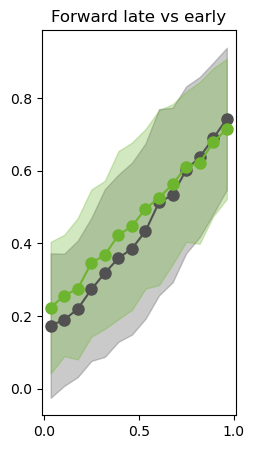

In [169]:
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = expert_master['neuron_rel_forward_replay_positions']
x = [item for sublist in x for item in sublist]
y = expert_master['neuron_rel_awake_positions_forwards']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, '#515151')
test_univariate_normality(x, y, alpha=0.05)


print('------------------ expert only regression ------------------------------------------')
import statsmodels.api as sm
group1_data = {'x': x, 'y': y}
# SaveFig(title_+'decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
df1 = pd.DataFrame(group1_data)
# Add a constant term to the independent variable
data = sm.add_constant(df1)
# data = sm.add_constant(df2)

# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()

# Print the summary statistics
# print(model.summary())

r = np.sign(model.params['x']) * np.sqrt(model.rsquared)


print(f"r = {r}")
print(f"r^2 = {model.rsquared}")
print(f"p-value = {model.pvalues['x']}")


print('------------------------------------------------------------')


x1 = learning_master['neuron_rel_forward_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = learning_master['neuron_rel_awake_positions_forwards']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, '#6DB52F')
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward late vs early')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)



SaveFig('expert_learning_forward_spike_positions.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')





late vs early reverse

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5810.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipyker

--- x-axis ---
 Shapiro–Wilk:    W=0.957, p=0.000 -> non-normal
 D’Agostino K²: K²=1578.353, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.965, p=0.000 -> non-normal
 D’Agostino K²: K²=2065.599, p=0.000 -> non-normal

--- x-axis ---
 Shapiro–Wilk:    W=0.969, p=0.000 -> non-normal
 D’Agostino K²: K²=604.677, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.971, p=0.000 -> non-normal
 D’Agostino K²: K²=977.499, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic              0.00724
p-value                       0.942
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA pseudo-F: 0.00724
PERMANOVA p-value: 0.94200
PERMANOVA effect size R²: 0.66359


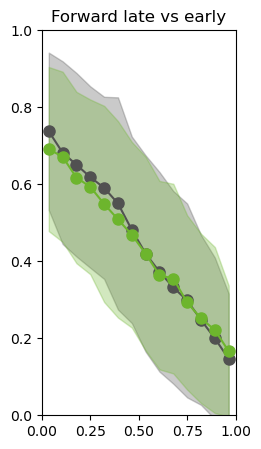

In [83]:

fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = expert_master['neuron_rel_reverse_replay_positions']
x = [item for sublist in x for item in sublist]
y = expert_master['neuron_rel_awake_positions_reverse']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, '#515151')
test_univariate_normality(x, y, alpha=0.05)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

x1 = learning_master['neuron_rel_reverse_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = learning_master['neuron_rel_awake_positions_reverse']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, '#6DB52D')
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward late vs early')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)

SaveFig('expert_learning_reverse_spike_positions.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


expert vs h lesion forward 

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6727.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipyker

--- x-axis ---
 Shapiro–Wilk:    W=0.962, p=0.000 -> non-normal
 D’Agostino K²: K²=950.775, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.963, p=0.000 -> non-normal
 D’Agostino K²: K²=2709.202, p=0.000 -> non-normal

--- x-axis ---
 Shapiro–Wilk:    W=0.956, p=0.000 -> non-normal
 D’Agostino K²: K²=294.539, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.930, p=0.000 -> non-normal
 D’Agostino K²: K²=4626.179, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.015783
p-value                       0.922
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA pseudo-F: 0.01578
PERMANOVA p-value: 0.92200
PERMANOVA effect size R²: 0.66393


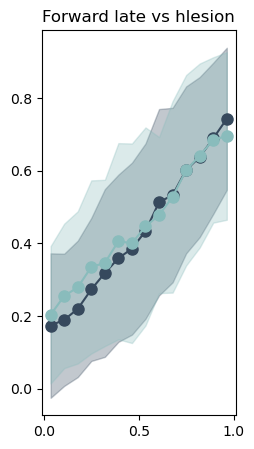

In [84]:
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = expert_master['neuron_rel_forward_replay_positions']
x = [item for sublist in x for item in sublist]
y = expert_master['neuron_rel_awake_positions_forwards']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, '#36495D')
test_univariate_normality(x, y, alpha=0.05)

x1 = hlesion_master['neuron_rel_forward_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = hlesion_master['neuron_rel_awake_positions_forwards']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, '#89BCBC')
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward late vs hlesion')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)

SaveFig('expert_hlesion_forward_spike_positions.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

expert vs hlesion reverse

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_32512\2652795036.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
c:\miniconda\envs\analysis_main\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5810.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipyker

--- x-axis ---
 Shapiro–Wilk:    W=0.957, p=0.000 -> non-normal
 D’Agostino K²: K²=1578.353, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.965, p=0.000 -> non-normal
 D’Agostino K²: K²=2065.599, p=0.000 -> non-normal

--- x-axis ---
 Shapiro–Wilk:    W=0.954, p=0.000 -> non-normal
 D’Agostino K²: K²=274.771, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.928, p=0.000 -> non-normal
 D’Agostino K²: K²=4815.346, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.082236
p-value                        0.78
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA pseudo-F: 0.08224
PERMANOVA p-value: 0.78000
PERMANOVA effect size R²: 0.66504


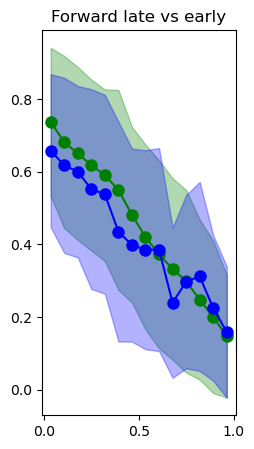

In [80]:
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = expert_master['neuron_rel_reverse_replay_positions']
x = [item for sublist in x for item in sublist]
y = expert_master['neuron_rel_awake_positions_reverse']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, 'green')
test_univariate_normality(x, y, alpha=0.05)

x1 = hlesion_master['neuron_rel_reverse_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = hlesion_master['neuron_rel_awake_positions_reverse']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, 'blue')
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward late vs early')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)

# reactivations per minute 

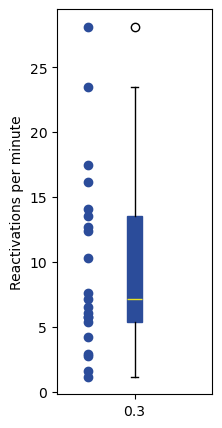

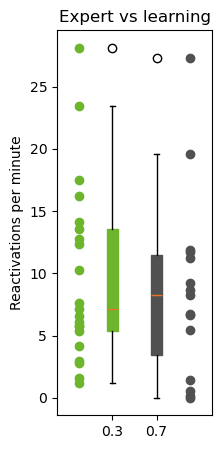

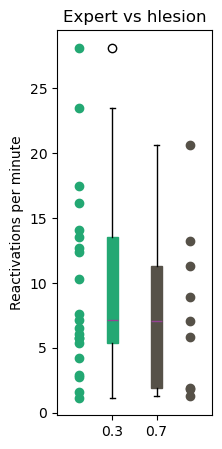

In [146]:
expert_reactivations_per_min = expert_master['reactivations_per_min']
learning_reactivations_per_min = learning_master['reactivations_per_min']
hlesion_reactivations_per_min = hlesion_master['reactivations_per_min']

# replace nan values with 0
expert_reactivations_per_min = [0 if np.isnan(item) else item for item in expert_reactivations_per_min]
learning_reactivations_per_min = [0 if np.isnan(item) else item for item in learning_reactivations_per_min]
hlesion_reactivations_per_min = [0 if np.isnan(item) else item for item in hlesion_reactivations_per_min]

########################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_reactivations_per_min)), expert_reactivations_per_min, 'o', color = '#2B4C9A')
ax.boxplot(expert_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#2B4C9A', color='#2B4C9A'), medianprops=dict(color='#EAE324'))

ax.set_ylabel('Reactivations per minute')

SaveFig('EXPERT_rpm.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

########################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_reactivations_per_min)), expert_reactivations_per_min, 'o', color = '#6DB52D')
ax.boxplot(expert_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#6DB52D', color='#6DB52D'), medianprops=dict(color='#EB7224'))

ax.plot(np.ones(len(learning_reactivations_per_min)), learning_reactivations_per_min, 'o', color = '#515151')
ax.boxplot(learning_reactivations_per_min, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#515151', color='#515151'), medianprops=dict(color='#EB7224'))

ax.set_ylabel('Reactivations per minute')

ax.set_title('Expert vs learning')
SaveFig('expert_learning_rpm.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

########################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_reactivations_per_min)), expert_reactivations_per_min, 'o', color = '#23A873')
ax.boxplot(expert_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#23A873', color='#23A873'), medianprops=dict(color='#934393'))

ax.plot(np.ones(len(hlesion_reactivations_per_min)), hlesion_reactivations_per_min, 'o', color = '#565148')
ax.boxplot(hlesion_reactivations_per_min, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#565148', color='#565148'), medianprops=dict(color='#934393'))

ax.set_ylabel('Reactivations per minute')

ax.set_title('Expert vs hlesion')

SaveFig('expert_hlesion_rpm.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

stats

In [149]:

import scipy

a = [x for x in expert_reactivations_per_min if not np.isnan(x)]
b = [x for x in learning_reactivations_per_min if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))

print(effect_size(x=a, y=b, test='ttest'))

print('-------------------')

a = [x for x in expert_reactivations_per_min if not np.isnan(x)]
b = [x for x in hlesion_reactivations_per_min if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))

effect_size(x=a, y=b, test='ttest')



ShapiroResult(statistic=np.float64(0.9040141937948986), pvalue=np.float64(0.04188870300214873))
ShapiroResult(statistic=np.float64(0.8927178662786185), pvalue=np.float64(0.07372786707541182))
TtestResult(statistic=np.float64(0.48362360183438574), pvalue=np.float64(0.6317532756923558), df=np.float64(34.0))
{'cohens_d': np.float64(0.16349461791098446)}
-------------------
ShapiroResult(statistic=np.float64(0.9040141937948986), pvalue=np.float64(0.04188870300214873))
ShapiroResult(statistic=np.float64(0.9158435575030686), pvalue=np.float64(0.35894019029518986))
TtestResult(statistic=np.float64(0.6410640952169872), pvalue=np.float64(0.5266938322308548), df=np.float64(28.0))


{'cohens_d': np.float64(0.25540604900680364)}

# event lengths

dict_keys(['animals', 'reactivations_per_min', 'event_lens', 'regression', 'binned_rate', 'bins_relative_so', 'start_end', 'coactive_freqs', 'ordered_misordered', 'task_nontask', 'awake_seqbyseq_neuron_involvements', 'sleep_seqbyseq_neuron_involvements', 'neuron_rel_awake_positions_reverse', 'neuron_rel_reverse_replay_positions', 'neuron_rel_awake_positions_forwards', 'neuron_rel_forward_replay_positions'])


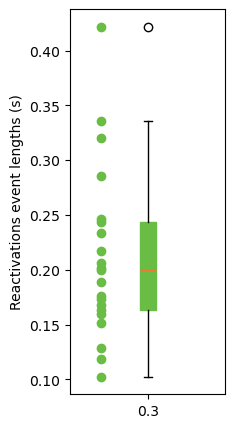

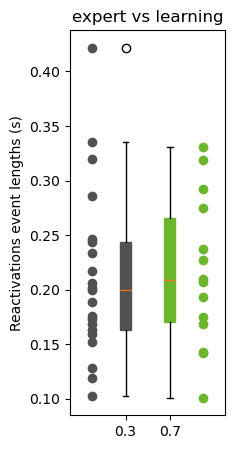

Text(0.5, 1.0, 'expert vs h_lesion')

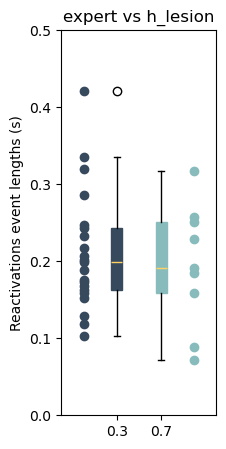

In [160]:
print(expert_master.keys())
expert_event_lens = expert_master['event_lens']
learning_event_lens = learning_master['event_lens']
hlesion_event_lens = hlesion_master['event_lens']

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_event_lens)), expert_event_lens, 'o', color = '#69BD45')
ax.boxplot(expert_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

ax.set_ylabel('Reactivations event lengths (s)')

# SaveFig('expert_event_lengths.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

##############################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_event_lens)), expert_event_lens, 'o', color = '#515151')
ax.boxplot(expert_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#515151', color='#515151'), medianprops=dict(color='#EB7224'))

ax.plot(np.ones(len(learning_event_lens)), learning_event_lens, 'o', color = '#6DB52D')
ax.boxplot([x for x in learning_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#6DB52D', color='#6DB52D'), medianprops=dict(color='#EB7224'))

ax.set_ylabel('Reactivations event lengths (s)')

ax.set_title('expert vs learning')

SaveFig('expert_learning_event_lengths.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

##############################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(expert_event_lens)), expert_event_lens, 'o', color = '#36495D')
ax.boxplot(expert_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#36495D', color='#36495D'), medianprops=dict(color='#FED163'))

ax.plot(np.ones(len(hlesion_event_lens)), hlesion_event_lens, 'o', color = '#88BCBC')
ax.boxplot([x for x in hlesion_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#88BCBC', color='#88BCBC'), medianprops=dict(color='#FED163'))
ax.set_ylim(0, 0.5)
ax.set_ylabel('Reactivations event lengths (s)')

ax.set_title('expert vs h_lesion')


# SaveFig('expert_lesion_event_lengths.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats

In [162]:
a = [x for x in expert_event_lens if not np.isnan(x)]
b = [x for x in learning_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))

print(effect_size(x=b, y=a, test='ttest'))


###########################
print('-------------------')

a = [x for x in expert_event_lens if not np.isnan(x)]
b = [x for x in hlesion_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))

print(effect_size(x=a, y=b, test='ttest'))


ShapiroResult(statistic=np.float64(0.9220872358994365), pvalue=np.float64(0.09553227620482058))
ShapiroResult(statistic=np.float64(0.9682434705245807), pvalue=np.float64(0.8523133593589285))
TtestResult(statistic=np.float64(-0.16642299583693984), pvalue=np.float64(0.8688395990605398), df=np.float64(33.0))
{'cohens_d': np.float64(0.057421388854824104)}
-------------------
ShapiroResult(statistic=np.float64(0.9220872358994365), pvalue=np.float64(0.09553227620482058))
ShapiroResult(statistic=np.float64(0.9621845886732947), pvalue=np.float64(0.8208891175100859))
TtestResult(statistic=np.float64(0.543916603971253), pvalue=np.float64(0.5908040384854598), df=np.float64(28.0))
{'cohens_d': np.float64(0.2167015620528156)}


# warp 

In [150]:
import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels



bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

def extract_mean_warps(regression_df, bins_):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse, group in regression_df.groupby('mouse'):
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]

            
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)
    ax.set_ylim(0,0.4)


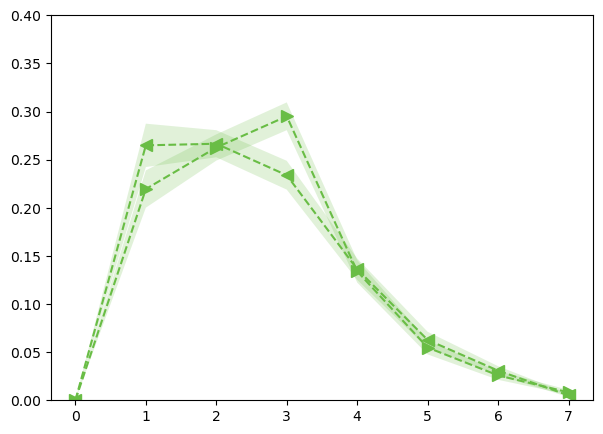

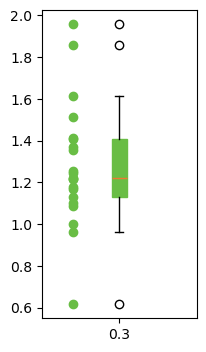

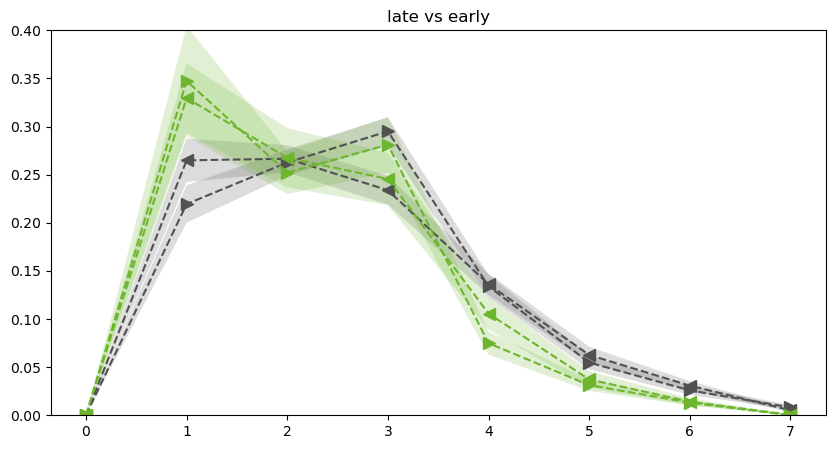

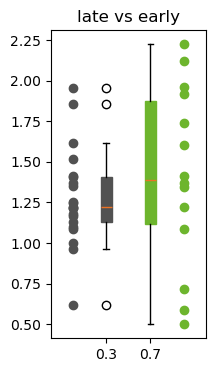

Text(0.5, 1.0, 'late vs hlesion')

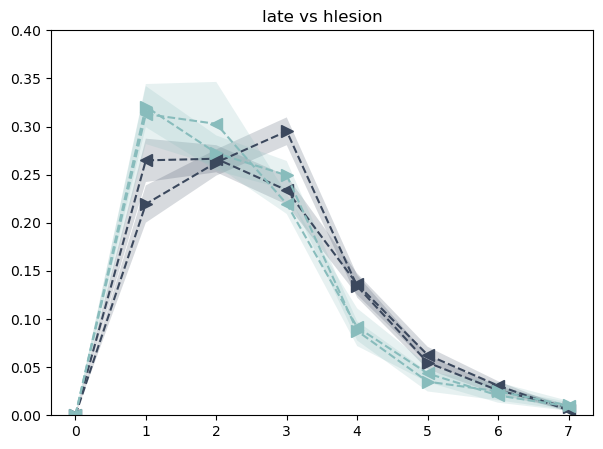

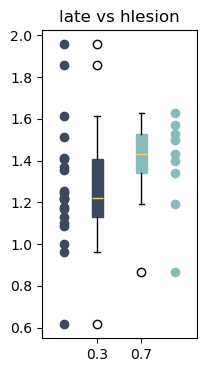

In [151]:

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

f_warp_factors, r_warp_factors, forward_total, reverse_total = extract_mean_warps(pd.DataFrame(expert_master['regression']), bins_)
color_ = '#69BD45'
fig,ax = plt.subplots(1, 1,figsize=(7, 5))
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)
# SaveFig('expert_warpz.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(forward_total)/np.array(reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
# SaveFig('expert_warp_forward_vs_reverse.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



###############################################################


fig,ax = plt.subplots(1, 1,figsize=(10, 5))
color_ = '#515151'
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)
ax.set_title('late vs early')

learning_f_warp_factors, learning_r_warp_factors,  learning_forward_total, learning_reverse_total= extract_mean_warps(pd.DataFrame(learning_master['regression']), bins_)
color_ = '#6DB52D'
plot_warp_factors(ax, learning_f_warp_factors, learning_r_warp_factors, bins_, color_)
ax.set_title('late vs early')
SaveFig('expert_learning_warpz.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(forward_total)/np.array(reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#515151')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#515151', color='#515151'), medianprops=dict(color='#EB7224'))
learning_proportion_forward_v_reverse = np.array(learning_forward_total)/np.array(learning_reverse_total)
ax.plot(np.ones(len(learning_proportion_forward_v_reverse)),learning_proportion_forward_v_reverse,'o', color = '#6DB52D')
ax.boxplot([x for x in learning_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#6DB52D', color='#6DB52D'), medianprops=dict(color='#EB7224'))
ax.set_title('late vs early')

SaveFig('expert_learning_warp_forward_vs_reverse.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



###############################################################


fig,ax = plt.subplots(1, 1,figsize=(7, 5))
color_ = '#3B485D'
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

hlesion_f_warp_factors, hlesion_r_warp_factors,  hlesion_forward_total, hlesion_reverse_total= extract_mean_warps(pd.DataFrame(hlesion_master['regression']), bins_)
color_ = '#88BCBC'
plot_warp_factors(ax, hlesion_f_warp_factors, hlesion_r_warp_factors, bins_, color_)
ax.set_title('late vs hlesion')
# SaveFig('expert_hlesion_warpz.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(forward_total)/np.array(reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#3B485D')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#3B485D', color='#3B485D'), medianprops=dict(color='#FED163'))

hlesion_proportion_forward_v_reverse = np.array(hlesion_forward_total)/np.array(hlesion_reverse_total)
ax.plot(np.ones(len(hlesion_proportion_forward_v_reverse)),hlesion_proportion_forward_v_reverse,'o', color = '#88BCBC')
ax.boxplot([x for x in hlesion_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#88BCBC', color='#88BCBC'), medianprops=dict(color='#FED163'))
ax.set_title('late vs hlesion')
# SaveFig('expert_hlesion_warp_forward_vs_reverse.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')




stats for forward vs reverse

In [159]:
from scipy.stats import shapiro
from scipy.stats import ttest_1samp

# Perform one-sample t-test
statistic, p_value = ttest_1samp(learning_proportion_forward_v_reverse, 1.0)

# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)

effect_size(x=learning_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1)


Test statistic: 2.7941707260245114
P-value: 0.01519834383611054


{'cohens_d': np.float64(0.7467735383526514)}

In [158]:
print(scipy.stats.shapiro(learning_proportion_forward_v_reverse))
print(scipy.stats.shapiro(proportion_forward_v_reverse))
print(scipy.stats.shapiro(hlesion_proportion_forward_v_reverse))

## all normal so use ind t test
print(scipy.stats.ttest_ind(learning_proportion_forward_v_reverse,proportion_forward_v_reverse))
print(effect_size(x=learning_proportion_forward_v_reverse, y=proportion_forward_v_reverse, test='ttest'))
print(scipy.stats.ttest_ind(hlesion_proportion_forward_v_reverse,proportion_forward_v_reverse))

effect_size(x=hlesion_proportion_forward_v_reverse, y=proportion_forward_v_reverse, test='ttest')

ShapiroResult(statistic=np.float64(0.9531432047821607), pvalue=np.float64(0.610483741587827))
ShapiroResult(statistic=np.float64(0.9482890816718307), pvalue=np.float64(0.31607121231820307))
ShapiroResult(statistic=np.float64(0.8717341034643624), pvalue=np.float64(0.12832095317352704))
TtestResult(statistic=np.float64(0.9352717256365966), pvalue=np.float64(0.35644233473049425), df=np.float64(33.0))
{'cohens_d': np.float64(0.3226994032442534)}
TtestResult(statistic=np.float64(0.9322982681557084), pvalue=np.float64(0.3591523489259999), df=np.float64(28.0))


{'cohens_d': np.float64(0.3714365208442036)}

stats for warps - check normality

In [152]:
#check normality 

print(scipy.stats.shapiro([item for sublist in f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in r_warp_factors for item in sublist]))

print(scipy.stats.shapiro([item for sublist in learning_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in learning_r_warp_factors for item in sublist]))

print(scipy.stats.shapiro([item for sublist in hlesion_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in hlesion_r_warp_factors for item in sublist]))

print(' all are not normally distributed, so we will use a non-parametric test')

ShapiroResult(statistic=np.float64(0.8791377254296566), pvalue=np.float64(2.0434325170180656e-10))
ShapiroResult(statistic=np.float64(0.884456422558517), pvalue=np.float64(3.9222018000852367e-10))
ShapiroResult(statistic=np.float64(0.7595629400888902), pvalue=np.float64(2.9489289756782997e-12))
ShapiroResult(statistic=np.float64(0.8200564384166864), pvalue=np.float64(2.256009733628079e-10))
ShapiroResult(statistic=np.float64(0.8441983065085041), pvalue=np.float64(3.28037500536712e-07))
ShapiroResult(statistic=np.float64(0.8353747357978635), pvalue=np.float64(1.753660762010856e-07))
 all are not normally distributed, so we will use a non-parametric test


permanova - forward vs reverse

In [153]:
# PERMANOVA forward vs reverse diff
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

def permanova_forward_vs_reverse(f_warp_factors, r_warp_factors):
    grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
permanova_forward_vs_reverse(f_warp_factors, r_warp_factors)
print('-------------------')
permanova_forward_vs_reverse(learning_f_warp_factors, learning_r_warp_factors)
print('-------------------')
permanova_forward_vs_reverse(hlesion_f_warp_factors, hlesion_r_warp_factors)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic             2.774464
p-value                    0.047395
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.74190
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.343782
p-value                    0.744926
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.60397
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             0.405624
p-value                    0.754925
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect si

permanova groups 

In [154]:
def group_difference_permanova(f_warp_factors, r_warp_factors, learning_f_warp_factors, learning_r_warp_factors):

    # grouping = ['control_forwards']*len(np.vstack(e_f_warp_factors)) + ['control_reverse']*len(np.vstack(e_r_warp_factors)) + ['lesion_forwards']*len(np.vstack(hl_f_warp_factors)) + ['lesion_reverse']*len(np.vstack(hl_r_warp_factors))
    grouping = ['control']*len(np.vstack(f_warp_factors)) + ['control']*len(np.vstack(r_warp_factors)) + ['test']*len(np.vstack(learning_f_warp_factors)) + ['test']*len(np.vstack(learning_r_warp_factors))
    # data is stacked so that each row is a sample (animal) and each colum is a variable/test

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors+learning_f_warp_factors+learning_r_warp_factors), metric='euclidean')

    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
    return grouping

# PERMANOVA late vs early diff
el_grouping = group_difference_permanova(f_warp_factors, r_warp_factors, learning_f_warp_factors, learning_r_warp_factors)
print('------------------- ')
# PERMANOVA late vs early diff
eh_grouping = group_difference_permanova(f_warp_factors, r_warp_factors, hlesion_f_warp_factors, hlesion_r_warp_factors)


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      70
number of groups                  2
test statistic             5.646559
p-value                      0.0035
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.64602
------------------- 
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      60
number of groups                  2
test statistic             5.272963
p-value                      0.0024
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.72018


post-hoc comparisions

In [155]:
import numpy as np
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform

def pairwise_permanova_by_feature(data, group_labels, method='bonferroni', permutations=10000):
    """
    Perform pairwise PERMANOVA on each feature column, correcting p-values
    across all feature×pairwise tests. For any pair where the feature is
    constant, record statistic=0, p_value=1 instead of running PERMANOVA.
    Returns a list of dicts:
      feature, group1, group2, test_stat, p_value, permutations
    """
    unique_groups = np.unique(group_labels)
    pairwise_combinations = list(combinations(unique_groups, 2))

    results = []
    all_pvals = []

    n_features = data.shape[1]

    for feat_idx in range(n_features):
        feat = data[:, feat_idx]

        for g1, g2 in pairwise_combinations:
            mask = np.isin(group_labels, [g1, g2])
            sub_feat = feat[mask]
            sub_labels = group_labels[mask]

            # If the feature is constant across these two groups, skip PERMANOVA:
            if np.unique(sub_feat).size == 1:
                stat, pval = 0.0, 1.0
                r2 = 0
            else:
                # Compute distances and run PERMANOVA
                dist_mat = squareform(pdist(sub_feat[:, None], metric='euclidean'))
                dist_mat = np.ascontiguousarray(dist_mat)
                ids = [str(i) for i in range(len(sub_labels))]
                dm = DistanceMatrix(dist_mat, ids)
                res = permanova(dm, sub_labels, permutations=permutations)
                stat, pval = res["test statistic"], res["p-value"]
                
                    #Compute R² manually (effect size)
                # ss_total = sum of squared distances / n
                D = dm.data        # <-- this is the fix
                n = len(sub_labels)
                ss_total = np.sum(D**2) / n

                # ss_between: sum of squared group means
                group_labels = np.array(sub_labels)
                unique_groups = np.unique(group_labels)
                ss_between = 0
                for g in unique_groups:
                    idx = np.where(group_labels == g)[0]
                    Di = D[np.ix_(idx, idx)]
                    ss_between += len(idx) * (Di.mean() ** 2)

                r2 = ss_between / ss_total
                
            results.append({
                "feature": feat_idx,
                "group1": g1,
                "group2": g2,
                "test_stat": stat,
                "p_value": pval,
                "permutations": permutations,
                "R2": r2
            })
            all_pvals.append(pval)

    # Multiple testing correction
    corrected = multipletests(all_pvals, method=method)[1]
    for i, cp in enumerate(corrected):
        results[i]["p_value"] = cp

    return results

####################################################################################

# late vs early learning

# Combine them correctly:
combined_data = np.vstack([
    np.asarray(f_warp_factors),
    np.asarray(r_warp_factors),
    np.asarray(learning_f_warp_factors),
    np.asarray(learning_r_warp_factors)
])
combined_labels = np.array(el_grouping)

feature_results = pairwise_permanova_by_feature(
    combined_data,
    combined_labels,
    method='bonferroni',
    permutations=10000
)

print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
for res in feature_results:
    p = res["p_value"]
    if p < 0.05:
        stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
        print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
        print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}, R2: {res['R2']:.4f}")
        print("---")
        
print('_-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-_')  

#### late vs hlesion

# Combine them correctly:
combined_data = np.vstack([
    np.asarray(f_warp_factors),
    np.asarray(r_warp_factors),
    np.asarray(hlesion_f_warp_factors),
    np.asarray(hlesion_r_warp_factors)
])
combined_labels = np.array(eh_grouping)

feature_results = pairwise_permanova_by_feature(
    combined_data,
    combined_labels,
    method='bonferroni',
    permutations=10000
)

print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
for res in feature_results:
    p = res["p_value"]
    if p < 0.05:
        stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
        print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
        print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}, R2: {res['R2']:.4f}")
        print("---")
        

Significant feature-wise pairwise PERMANOVA results (α=0.05):
Feature 1: control vs test
  statistic = 8.6499, p (corr.) = 0.0224 *, R2: 0.4629
---
Feature 4: control vs test
  statistic = 11.8730, p (corr.) = 0.007199 **, R2: 0.5320
---
Feature 5: control vs test
  statistic = 9.3507, p (corr.) = 0.0304 *, R2: 0.5558
---
Feature 6: control vs test
  statistic = 11.1961, p (corr.) = 0.0112 *, R2: 0.5417
---
Feature 7: control vs test
  statistic = 11.8441, p (corr.) = 0.0024 **, R2: 0.3573
---
_-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-__-_-_-_
Significant feature-wise pairwise PERMANOVA results (α=0.05):
Feature 1: control vs test
  statistic = 8.2245, p (corr.) = 0.0424 *, R2: 0.5069
---
Feature 4: control vs test
  statistic = 10.4883, p (corr.) = 0.02 *, R2: 0.5318
---


# reactivation rate vs time 

In [32]:
def plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(10, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(nrem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(nrem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, markersize = 10, markeredgewidth = 0, alpha = 0.8)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(rem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(rem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    SaveFig(title_+'decay.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}
    SaveFig(title_+'decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
    return group1_data, group2_data

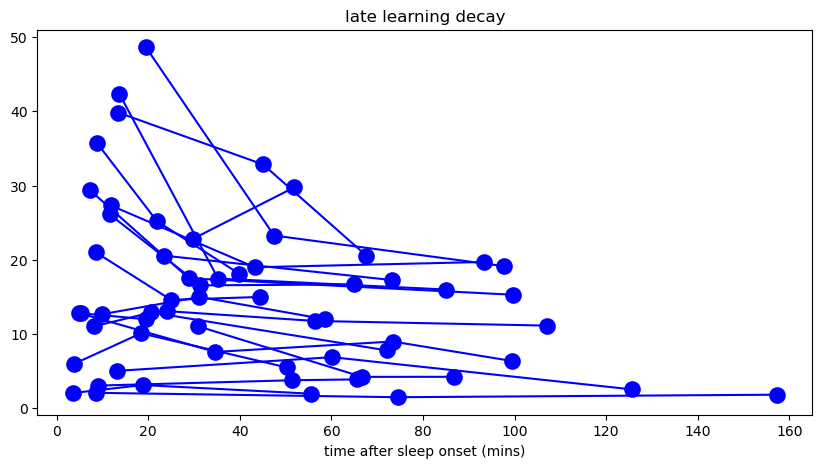

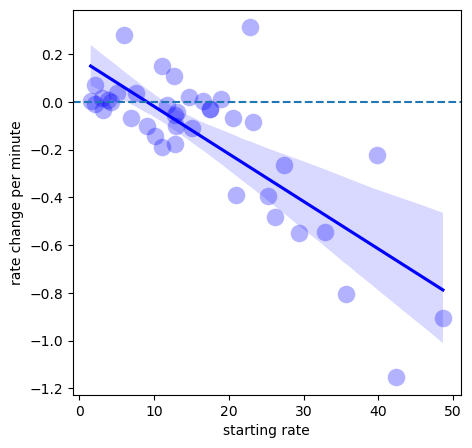

model p value (f statistic) = 
3.1712640703044366e-09
r2 = 
0.6071427149335138


In [33]:

fig,ax = plt.subplots(1, 1,figsize=(10, 5))
AA_rate = []
AA_post_so_time = []
times = []
rates = []
for i,item in enumerate(expert_master['binned_rate']):
    across_chunks_x = []
    across_chunks_y = []
    for e,chunk_item in enumerate(item):
        #mean for each time series across chunks
        across_chunks_x += [np.mean(expert_master['bins_relative_so'][i][e])]
        across_chunks_y += [np.mean(chunk_item)]
    AA_rate+=[across_chunks_y]
    AA_post_so_time+=[across_chunks_x]
    ax.plot(across_chunks_x,across_chunks_y, '-o',c = 'blue', alpha = 1, markersize = 12, markeredgewidth = 0)
    # save out stuff for plot 2
    rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
    times += across_chunks_y[0:-1]
    rates += list(rate_change_per_min)
    

ax.set_title('late learning decay')
ax.set_xlabel('time after sleep onset (mins)')

SaveFig('expert_decay.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
sns.regplot(x=times, y=rates, ax = ax, color = 'blue',scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
ax.set_xlabel('starting rate')
ax.set_ylabel('rate change per minute')
ax.axhline(0,0,ls ='--')

SaveFig('expert_decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

group1_data = {'x': times, 'y': rates}
# SaveFig(title_+'decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
df1 = pd.DataFrame(group1_data)

# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()

# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)


In [ ]:
# flatten list
x = [item for sublist in AA_post_so_time for item in sublist]
y = [item for sublist in AA_rate for item in sublist]

data_for_stats = {'x': x, 'y': y}
df_stats = pd.DataFrame(data_for_stats)

import statsmodels.api as sm

# Add a constant term to the independent variable
data = sm.add_constant(df_stats)
# data = sm.add_constant(df2)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
# Print the summary statistics
print(model.summary())
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)

print(f'r = {r}')
print(model.rsquared)
print(model.pvalues['x'])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.820
Date:                Thu, 28 Aug 2025   Prob (F-statistic):             0.0190
Time:                        19:01:19   Log-Likelihood:                -227.53
No. Observations:                  61   AIC:                             459.1
Df Residuals:                      59   BIC:                             463.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0711      2.139      8.916      0.0

late vs early 

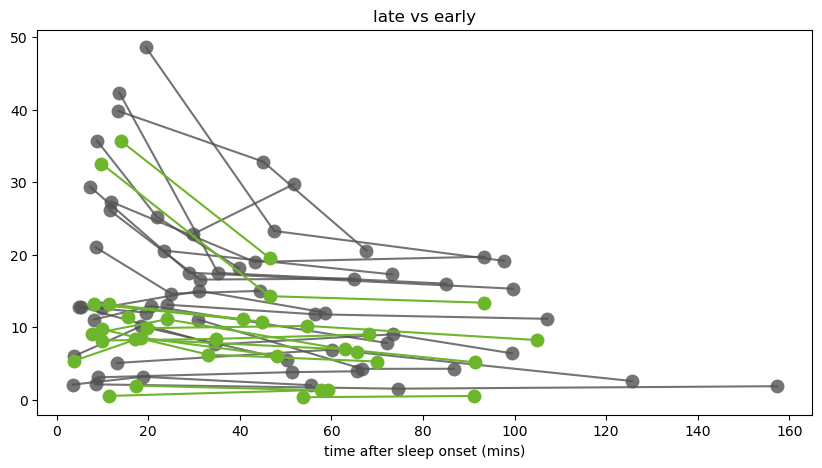

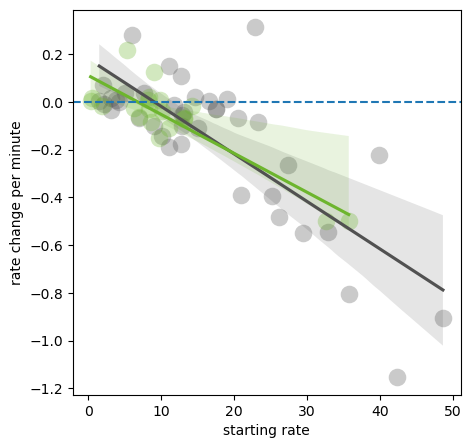

PLOT 2:
Group 1 (NREM):
model p value (f statistic) = 
3.1712640703044366e-09
r2 = 
0.6071427149335138
Group 2 (REM):
model p value (f statistic) = 
9.576838279216117e-07
r2 = 
0.7451712335388596


In [163]:
group1_data, group2_data = plot_decay(expert_master['binned_rate']  ,expert_master['bins_relative_so'],learning_master['binned_rate']  ,learning_master['bins_relative_so'], '#515151','#6DB52D','late vs early')

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)



In [175]:
### stats 

### effect of decay - significance

import statsmodels.api as sm

# Add a constant term to the independent variable
# data = sm.add_constant(df1)
data = sm.add_constant(df2)

# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()

# Print the summary statistics
print(model.summary())

r = np.sign(model.params['x']) * np.sqrt(model.rsquared)

print(r)
print(model.rsquared)
print(model.pvalues['x'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     52.64
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           9.58e-07
Time:                        12:56:38   Log-Likelihood:                 21.443
No. Observations:                  20   AIC:                            -38.89
Df Residuals:                      18   BIC:                            -36.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1108      0.031      3.582      0.0

In [165]:
### between groups

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict


# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)

# Create a grouping variable
groups = np.array(['nrem'] * len(df1) + ['rem'] * len(df2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)


                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3047 2.0000 57.0000 65.0448 0.0000
         Pillai's trace 0.6953 2.0000 57.0000 65.0448 0.0000
 Hotelling-Lawley trace 2.2823 2.0000 57.0000 65.0448 0.0000
    Roy's greatest root 2.2823 2.0000 57.0000 65.0448 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9343 2.0000 57.0000  2.0025 0.1444
         Pillai's trace 0.0657 2.0000 57.0000  2.0025 0.1444
 Hotelling-Lawley trace 0.0703 2.0000 57.0

expert vs lesion

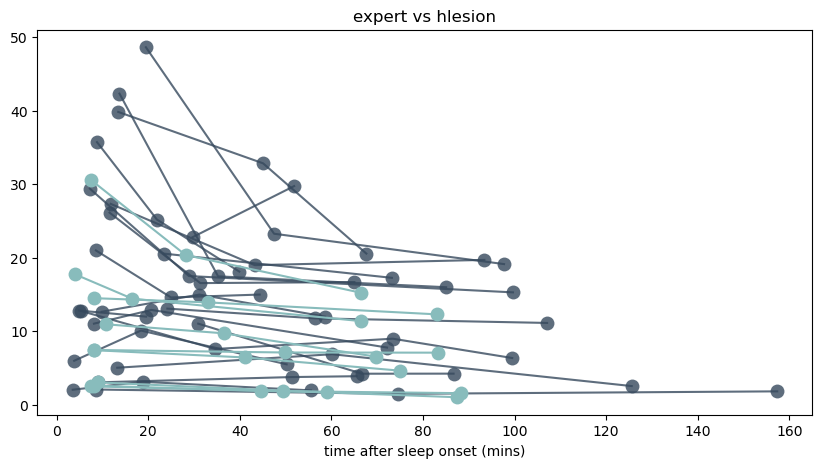

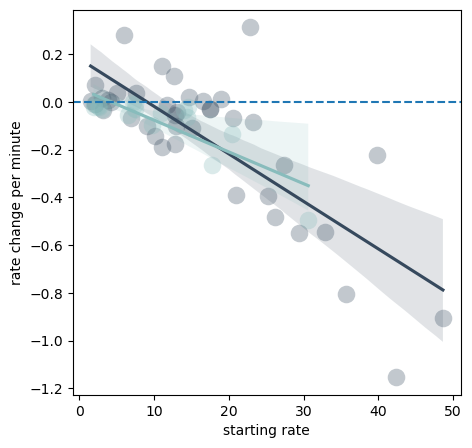

<Figure size 640x480 with 0 Axes>

PLOT 2:
Group 1 (NREM):
model p value (f statistic) = 
3.1712640703044366e-09
r2 = 
0.6071427149335138
Group 2 (REM):
model p value (f statistic) = 
3.569632900446944e-05
r2 = 
0.6908297520445896


In [135]:
group1_data, group2_data = plot_decay(expert_master['binned_rate']  ,expert_master['bins_relative_so'],hlesion_master['binned_rate']  ,hlesion_master['bins_relative_so'], '#36495D','#88BCBC','expert vs hlesion')

SaveFig('expert_hlesion_decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

# expert_master['binned_rate']    
# expert_master['bins_relative_so']

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

In [136]:
### between groups

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA


# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)

# Create a grouping variable
groups = np.array(['nrem'] * len(df1) + ['rem'] * len(df2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)



                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.2942 2.0000 54.0000 64.7869 0.0000
         Pillai's trace 0.7058 2.0000 54.0000 64.7869 0.0000
 Hotelling-Lawley trace 2.3995 2.0000 54.0000 64.7869 0.0000
    Roy's greatest root 2.3995 2.0000 54.0000 64.7869 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9146 2.0000 54.0000  2.5224 0.0897
         Pillai's trace 0.0854 2.0000 54.0000  2.5224 0.0897
 Hotelling-Lawley trace 0.0934 2.0000 54.0

# relative position

In [166]:
def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)
    
    


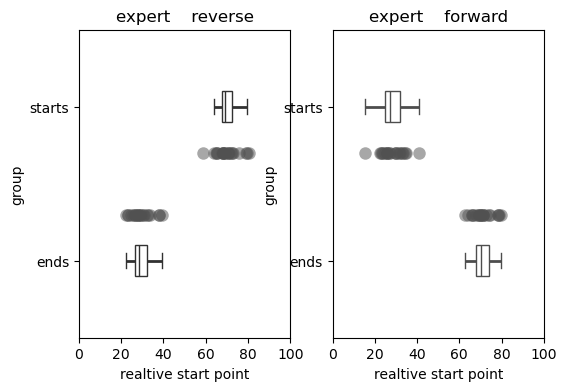

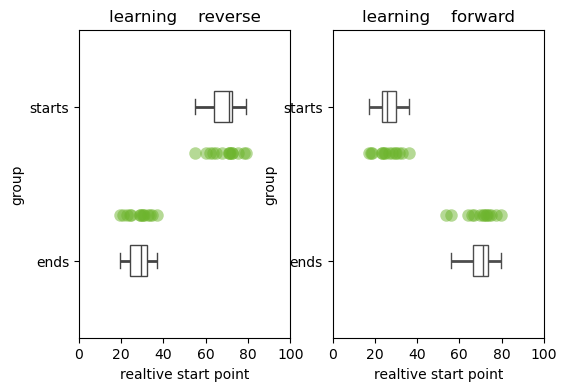

In [167]:



fig,[ax,ax2] = plt.subplots(1, 2,figsize=(6, 4)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(expert_master['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'expert','#515151')
SaveFig('expert_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(6, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(learning_master['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'learning','#6DB52D')
SaveFig('learning_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

# fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
# all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(hlesion_master['start_end']))
# plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'hlesion','#88BCBC')
# SaveFig('hlesion_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats

In [168]:

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict


expert_all_chunk_reverse_start_mean, expert_all_chunk_forward_start_mean, expert_all_chunk_reverse_end_mean, expert_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(expert_master['start_end']))
learning_all_chunk_reverse_start_mean, learning_all_chunk_forward_start_mean, learning_all_chunk_reverse_end_mean, learning_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(learning_master['start_end']))
hlesion_all_chunk_reverse_start_mean, hlesion_all_chunk_forward_start_mean, hlesion_all_chunk_reverse_end_mean, hlesion_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(hlesion_master['start_end']))


group1 = [x for x in expert_all_chunk_forward_start_mean if not np.isnan(x)] 
group2 = [x for x in expert_all_chunk_forward_end_mean if not np.isnan(x)] 
group3 = [x for x in expert_all_chunk_reverse_start_mean if not np.isnan(x)] 
group4 = [x for x in expert_all_chunk_reverse_end_mean if not np.isnan(x)] 
group5 = [x for x in learning_all_chunk_forward_start_mean if not np.isnan(x)] 
group6 = [x for x in learning_all_chunk_forward_end_mean if not np.isnan(x)] 
group7 = [x for x in learning_all_chunk_reverse_start_mean if not np.isnan(x)] 
group8 = [x for x in learning_all_chunk_reverse_end_mean if not np.isnan(x)] 
group9 = [x for x in learning_all_chunk_forward_start_mean if not np.isnan(x)] 
group10 = [x for x in learning_all_chunk_forward_end_mean if not np.isnan(x)] 
group11 = [x for x in learning_all_chunk_reverse_start_mean if not np.isnan(x)] 
group12 = [x for x in learning_all_chunk_reverse_end_mean if not np.isnan(x)] 

for group in [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12]:
    print(scipy.stats.shapiro(group))

## all are normal so use MANOVA

df_late = pd.DataFrame({
    'group':       ['late'] * len(expert_all_chunk_forward_start_mean),
    'forward_start': expert_all_chunk_forward_start_mean,
    'forward_end':   expert_all_chunk_forward_end_mean,
    'reverse_start': expert_all_chunk_reverse_start_mean,
    'reverse_end':   expert_all_chunk_reverse_end_mean,
})


df_early = pd.DataFrame({
    'group':       ['early'] * len(learning_all_chunk_forward_start_mean),
    'forward_start': learning_all_chunk_forward_start_mean,
    'forward_end':   learning_all_chunk_forward_end_mean,
    'reverse_start': learning_all_chunk_reverse_start_mean,
    'reverse_end':   learning_all_chunk_reverse_end_mean,
})


df_hlesion = pd.DataFrame({
    'group':       ['hlesion'] * len(hlesion_all_chunk_forward_start_mean),
    'forward_start': hlesion_all_chunk_forward_start_mean,
    'forward_end':   hlesion_all_chunk_forward_end_mean,
    'reverse_start': hlesion_all_chunk_reverse_start_mean,
    'reverse_end':   hlesion_all_chunk_reverse_end_mean,
})
print('_____________________________________________________________________________________________')
# Concatenate them:
df = pd.concat([df_late, df_early], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)


print('_____________________________________________________________________________________________')
# Concatenate them:
df = pd.concat([df_late, df_hlesion], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)



ShapiroResult(statistic=np.float64(0.9754605626019955), pvalue=np.float64(0.8480745849657958))
ShapiroResult(statistic=np.float64(0.9519369820631697), pvalue=np.float64(0.3703914541583487))
ShapiroResult(statistic=np.float64(0.9594133004721429), pvalue=np.float64(0.5043848873596806))
ShapiroResult(statistic=np.float64(0.9470380016996118), pvalue=np.float64(0.29908190783052324))
ShapiroResult(statistic=np.float64(0.9637848813734085), pvalue=np.float64(0.784581420635664))
ShapiroResult(statistic=np.float64(0.9202547156339049), pvalue=np.float64(0.22175810766571513))
ShapiroResult(statistic=np.float64(0.9576300556048714), pvalue=np.float64(0.6839399296094383))
ShapiroResult(statistic=np.float64(0.9608955185850074), pvalue=np.float64(0.7378204254888282))
ShapiroResult(statistic=np.float64(0.9637848813734085), pvalue=np.float64(0.784581420635664))
ShapiroResult(statistic=np.float64(0.9202547156339049), pvalue=np.float64(0.22175810766571513))
ShapiroResult(statistic=np.float64(0.957630055604

# coactive frequency 

In [14]:

# plot frequency of coactive events (1,2,3,4,etc.)

def plot_coactive_single(nrem_coactive_freqs_chunk, color_,var_string):   
    fig, ax= plt.subplots(1, 1,figsize=(3, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        ax.plot(np.ones(len(nrem_coactive_freqs_chunk[1]))*(1),nrem_coactive_freqs_chunk[1],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.median(nrem_coactive_freqs_chunk[1])]
        stds += [np.std(nrem_coactive_freqs_chunk[1])]
        break 
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]
    ax.plot(1.2,means[0],'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 9)
    ax.set_xlim(0,2)
    ax.set_ylabel('frequency')
    ax.set_title(var_string + ' coactive frequency')
    ax.set_ylim(0,1)


def plot_coactive_two_plus(nrem_coactive_freqs_chunk, color_,var_string): 
    max_keys = 6
    nrem_coactive_freqs_chunk_collapsed = collapse_above_keys(nrem_coactive_freqs_chunk,max_keys)   

    fig, ax= plt.subplots(1, 1,figsize=(7, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk_collapsed:
        if not item == 1:
            ax.plot(np.ones(len(nrem_coactive_freqs_chunk_collapsed[item]))*(item-0.1),nrem_coactive_freqs_chunk_collapsed[item],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
            x_ += [item]
            means += [np.mean(nrem_coactive_freqs_chunk_collapsed[item])]
            stds += [np.std(nrem_coactive_freqs_chunk_collapsed[item])]
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax.plot(x_,means,'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 8)
    ax.set_title(var_string + ' coactive frequency')
    ax.set_xlabel('number of coactive events')
    # SET THE X MARKERS 
    ax.set_xticks(np.arange(0, max_keys+2, 1))
    ax.set_xticklabels(['_','_','2','3','4','5','6+','_'])
    ax.set_ylim(0,0.4)
    
    return nrem_coactive_freqs_chunk_collapsed
    
# get a reference to the original dict
def collapse_above_keys(freqs,max_key):

    # prepare a new dict and a placeholder for the merged value
    new_freqs = {}
    merged = []

    for k, v in freqs.items():
        if k < max_key:
            # keep all keys < max_key unchanged
            new_freqs[k] = v
        else:
            # collect everything with key >= max_key
            merged.append(v)

    # now combine the collected values into one entry "6+"
    # — if your values are numbers, you can sum them:
    if not len(merged) == 0:
        try:
            new_freqs[6] = sum(merged)
        except TypeError:
            # otherwise assume they’re sequences (lists, arrays…) and flatten:
            import itertools
            new_freqs[6] = list(itertools.chain.from_iterable(merged))

    # replace in your master dict
    return new_freqs


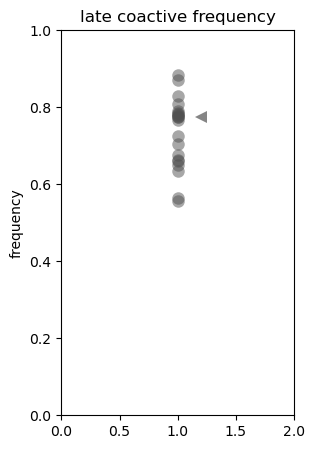

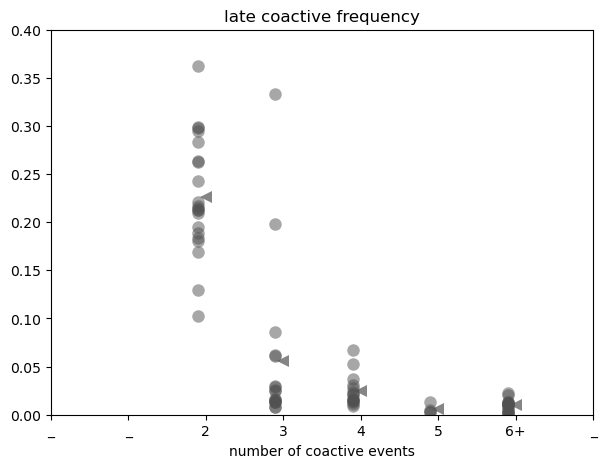

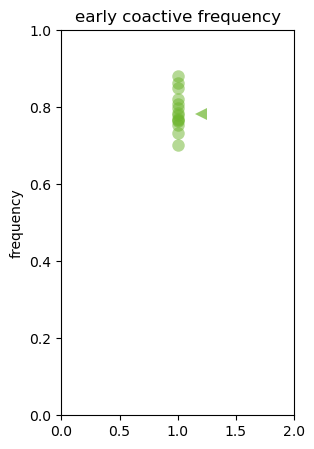

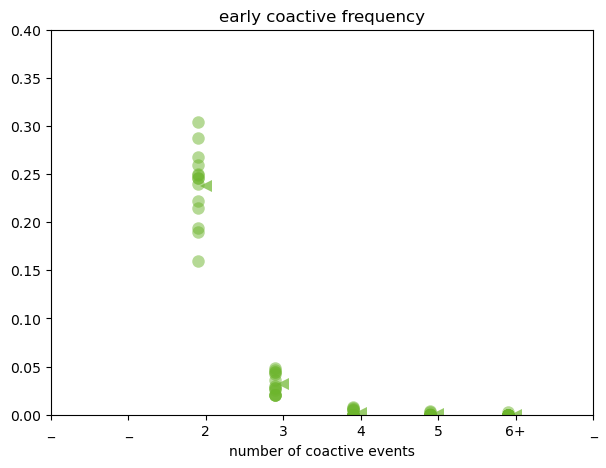

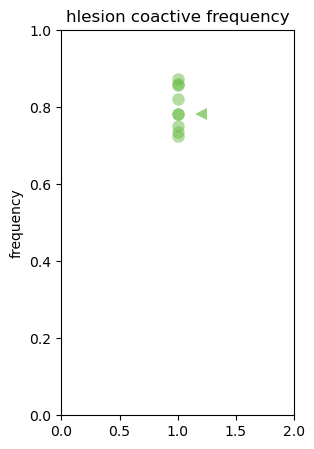

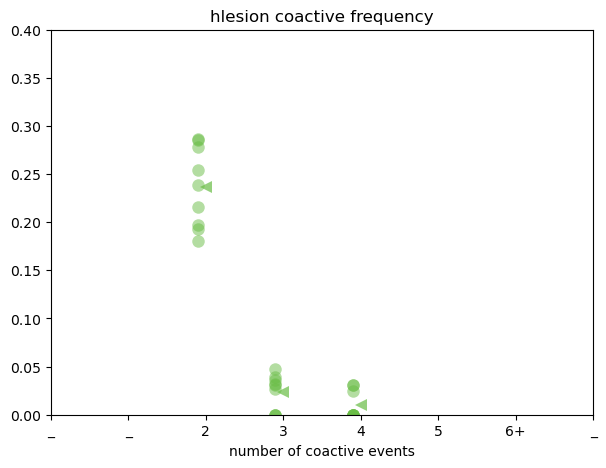

In [15]:


plot_coactive_single(expert_master['coactive_freqs'], '#515151','late')
SaveFig('late_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
expert_coactive_freqs_collapsed = plot_coactive_two_plus(expert_master['coactive_freqs'], '#515151','late')
SaveFig('late_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(learning_master['coactive_freqs'], '#6DB52D','early')
SaveFig('early_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
_ = plot_coactive_two_plus(learning_master['coactive_freqs'], '#6DB52D','early')
SaveFig('early_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(hlesion_master['coactive_freqs'], '#69BD45','hlesion')
# SaveFig('linked_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
_ = plot_coactive_two_plus(hlesion_master['coactive_freqs'], '#69BD45','hlesion')
# SaveFig('hlesion_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



stats for expert only plot 


In [63]:
import math 

def poisson_probability(rate, k):
    """Calculate Poisson probability of k events occurring given the rate."""
    return math.exp(-rate) * (rate ** k) / math.factorial(k)

def calculate_probabilities(rate_per_second, event_length_s):
    # Convert event length from milliseconds to seconds
    
    # Calculate the rate per 0.3 seconds considering event length
    rate_per_0p3_seconds = rate_per_second *(0.3 + event_length_s)
    
    results = {}
    total_probability = 0  # Variable to store the total probability
    
    for k in range(1, 7):  # Include probabilities for 1 to 6 events
        probability = poisson_probability(rate_per_0p3_seconds, k)
        results[k] = probability
        total_probability += probability  # Add probability to the total
    
    # Calculate percentages
    percentages = {k: (probability / total_probability) * 100 for k, probability in results.items()}
    
    return rate_per_0p3_seconds, results, percentages


## stats

# Input parameters
rate_per_second = np.mean(expert_master['reactivations_per_min'])/60
event_length_s = np.nanmean(expert_master['event_lens'])

# Calculate probabilities and percentages
rate_per_0p3_seconds, results, percentages = calculate_probabilities(rate_per_second, event_length_s)

# Display results
print(f"Using a rate of {rate_per_0p3_seconds:.6f} events per 0.3 seconds.")
print("Probability of events co-occurring within 0.3 + mean event length:")
for k, probability in results.items():
    print(f"{k} events co-occurring: Probability {probability:.6f}, Percentage {percentages[k]:.2f}%")
    
    
# test each one for significance from expected

from scipy.stats import shapiro
from scipy.stats import ttest_1samp

expect_percentages= [0.95,0.04,0.011,0,0,0]
for i,key in enumerate(expert_coactive_freqs_collapsed):
    data = np.array(expert_coactive_freqs_collapsed[key])
    
    print('-------')
    print(key)

    ### all normal so use t test 
    
    # Hypothesized value (e.g., population mean or constant)
    hypothesized_value = expect_percentages[i]

    # Perform one-sample t-test
    statistic, p_value = ttest_1samp(data, hypothesized_value)

    # Print the test statistic and p-value
    print("Test statistic:", statistic)
    print("P-value:", p_value)
    
    print('cohens d')
    print(effect_size(x=data, test='one_sample_ttest',popmean=hypothesized_value))


Using a rate of 0.083287 events per 0.3 seconds.
Probability of events co-occurring within 0.3 + mean event length:
1 events co-occurring: Probability 0.076631, Percentage 95.89%
2 events co-occurring: Probability 0.003191, Percentage 3.99%
3 events co-occurring: Probability 0.000089, Percentage 0.11%
4 events co-occurring: Probability 0.000002, Percentage 0.00%
5 events co-occurring: Probability 0.000000, Percentage 0.00%
6 events co-occurring: Probability 0.000000, Percentage 0.00%
-------
1
Test statistic: -10.811060125223838
P-value: 8.392844914474116e-10
cohens d
{'cohens_d': np.float64(-2.35916673174081)}
-------
2
Test statistic: 13.911314911292985
P-value: 9.575349766013606e-12
cohens d
{'cohens_d': np.float64(3.0356977903508566)}
-------
3
Test statistic: 2.181275848746699
P-value: 0.04442858080287187
cohens d
{'cohens_d': np.float64(0.5290371013524383)}
-------
4
Test statistic: 5.963697087429965
P-value: 3.464717069681714e-05
cohens d
{'cohens_d': np.float64(1.53981996676279

stats


In [88]:
from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

def permanova_coactive_freqs(dat1, dat2):
    df = pd.DataFrame()
    df['groups'] = ['control']*len(dat1[1])  + ['lesion']*len(dat2[1])

    for key in dat1:
        current_var = dat1[key]
        while len(current_var)<len(dat1[1]):
            current_var +=[0]
        
        try:
            dat2[key]
            current_var_l = dat2[key]
            while len(current_var_l)<len(dat2[1]):
                current_var_l +=[0]
        except:
            current_var_l = [0]*len(dat2[1])
            
            
        df[str(key)] = current_var + current_var_l
        

    # Calculate the Euclidean distance matrix
    values = df[['1', '2', '3', '4', '5', '6']].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)

    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(f"PERMANOVA effect size R²: {r2:.5f}")

permanova_coactive_freqs(expert_master['coactive_freqs'], learning_master['coactive_freqs'])
print('__________________')
permanova_coactive_freqs(expert_master['coactive_freqs'], hlesion_master['coactive_freqs'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  2
test statistic             2.318469
p-value                    0.081992
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.62969
__________________
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             1.929107
p-value                    0.136486
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.62409


# ordered v disordered 

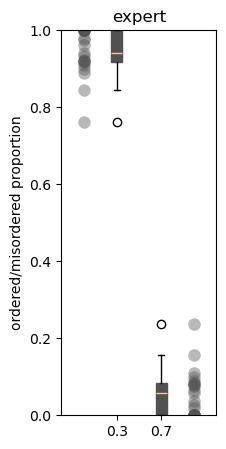

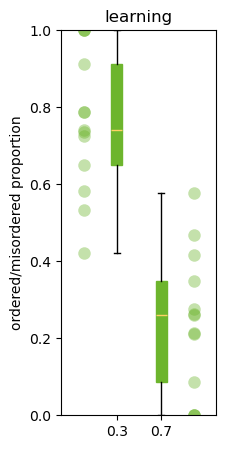

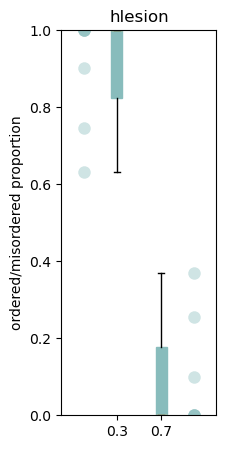

In [171]:

def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2, color_):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = color_,alpha = 0.4, markeredgewidth = 0, markersize = 9)
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor=color_, color=color_), medianprops=dict(color='#FED163'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = color_,alpha = 0.4, markeredgewidth = 0, markersize = 9)
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor=color_, color=color_), medianprops=dict(color='#FED163'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    ax.set_ylim(0, 1)
    
# '#69BD45'
# '#32495C'



plot_ordered_misrodered(expert_master['ordered_misordered'],'expert','ordered/misordered proportion', '#515151')
# SaveFig('expert_ordered_misordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(learning_master['ordered_misordered'],'learning','ordered/misordered proportion','#6DB52D')
# SaveFig('learning_ordered_misordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_ordered_misrodered(hlesion_master['ordered_misordered'],'hlesion','ordered/misordered proportion', '#88BCBC')
# SaveFig('hlesion_ordered_misordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


stats - ordered vs disovered

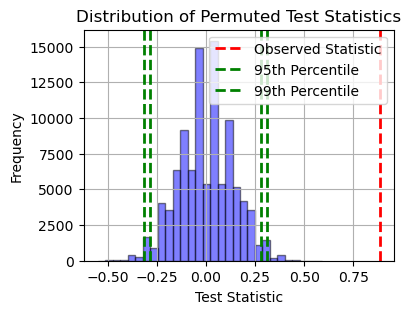

- p-value: 0.0
- 99th percentile of permuted statistics: 0.31221594183837026
- Observed Test Statistic: 0.8835621876858357
cohens d = 14.344563129258281
------------------


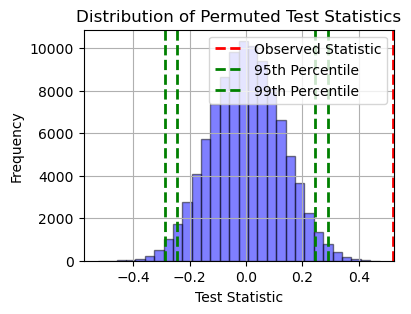

- p-value: 0.0
- 99th percentile of permuted statistics: 0.28962773329414193
- Observed Test Statistic: 0.5198639917680165
cohens d = 2.8145362289994527
------------------


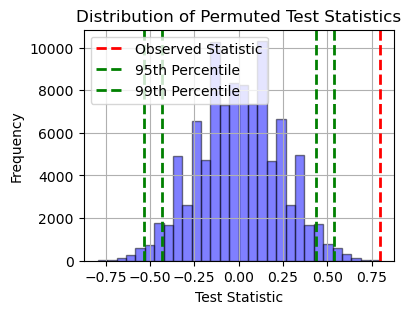

- p-value: 0.00025
- 99th percentile of permuted statistics: 0.5362844338176406
- Observed Test Statistic: 0.7937674270149195
cohens d = 5.2723039801951055


In [172]:

def cohens_d(x, y):
    """
    Compute Cohen's d for two independent samples.
    """
    x = np.array(x)
    y = np.array(y)
    nx = len(x)
    ny = len(y)
    # Pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx + ny - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

def permutation_test(list1, list2):
    # Define your test statistic function
    def test_statistic(list1, list2):
        return np.mean(list1) - np.mean(list2)

    # Compute the observed test statistic
    observed_statistic = test_statistic(list1, list2)

    # Combine the two lists
    combined_data = list1 + list2

    # Number of permutations
    num_permutations = 100000

    # Initialize an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Permutation test
    for i in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two lists
        permuted_list1 = combined_data[:len(list1)]
        permuted_list2 = combined_data[len(list1):]
        
        # Compute the test statistic for the permuted data
        permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

    # Calculate the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)


    plt.figure(figsize=(4, 3))
    plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of Permuted Test Statistics')
    plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
    plt.xlabel('Test Statistic')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    print("- p-value:", p_value)
    print('- 99th percentile of permuted statistics:',np.percentile(permuted_statistics, 99))
    print("- Observed Test Statistic:", observed_statistic)



    
    
list1 = [float(item[0]) for item in expert_master['ordered_misordered']] 
list2 = [float(item[1]) for item in expert_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')
# # Compute Cohen's d
# res = pg.compute_effsize(list1, list2, eftype='cohen')
# print(f"Cohen's d = {res:.3f}")
# delta = pg.compute_effsize(list1, list2, eftype='cliff')
# print("Cliff's delta =", delta)

print('------------------')
list1 = [float(item[0]) for item in learning_master['ordered_misordered']] 
list2 = [float(item[1]) for item in learning_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list1 = [float(item[0]) for item in hlesion_master['ordered_misordered']] 
list2 = [float(item[1]) for item in hlesion_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

stats - between groups 

In [173]:
list1 = [float(item[0]) for item in expert_master['ordered_misordered']] 
list2 = [float(item[1]) for item in expert_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in learning_master['ordered_misordered']] 
list2 = [float(item[1]) for item in learning_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in hlesion_master['ordered_misordered']] 
list2 = [float(item[1]) for item in hlesion_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

# use non-parametric permanova since not all are normal


ShapiroResult(statistic=np.float64(0.8501660492808003), pvalue=np.float64(0.004275777782515545))
ShapiroResult(statistic=np.float64(0.850166049280801), pvalue=np.float64(0.004275777782515661))
ShapiroResult(statistic=np.float64(0.9402014901875838), pvalue=np.float64(0.4595166571342518))
ShapiroResult(statistic=np.float64(0.9402014901875838), pvalue=np.float64(0.4595166571342518))
ShapiroResult(statistic=np.float64(0.7568195318727229), pvalue=np.float64(0.014941651702752096))
ShapiroResult(statistic=np.float64(0.7568195318727227), pvalue=np.float64(0.01494165170275201))


In [174]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

def permanova_ordered_misordered(nrem, rem):

    df = pd.DataFrame(nrem + rem, columns=['ordered','misordered'])
    df['group'] = ['nrem']*len(nrem) + ['rem']*len(rem)

    # drop any NaNs
    df = df.dropna()

    # compute distance matrix
    dm = DistanceMatrix(
        squareform(pdist(df[['ordered','misordered']].values, 'euclidean'))
    )

    # run PERMANOVA
    res = permanova(dm, grouping=df['group'].tolist(), permutations=999)
    print(res)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(df['group'].tolist())
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(df['group'].tolist())
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    

    

permanova_ordered_misordered(expert_master['ordered_misordered'], learning_master['ordered_misordered'])
print('---------------------------------------------------')
permanova_ordered_misordered(expert_master['ordered_misordered'], hlesion_master['ordered_misordered'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                  2
test statistic            17.509105
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.40118
---------------------------------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             1.298629
p-value                       0.249
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.49564


# task related 

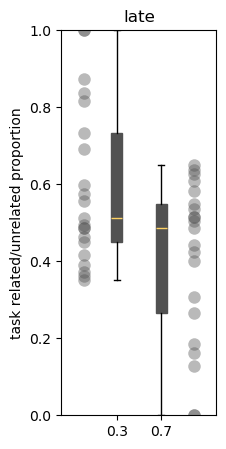

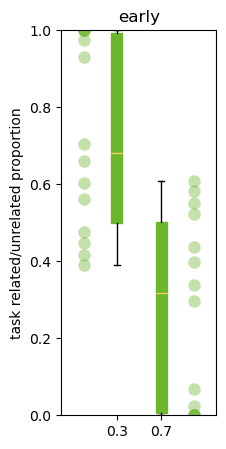

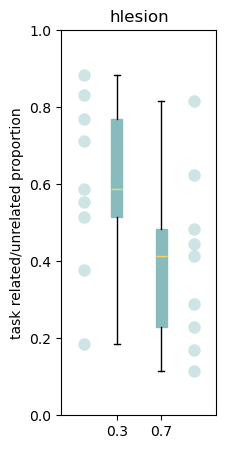

In [89]:

plot_ordered_misrodered(expert_master['task_nontask'],'late','task related/unrelated proportion','#515151')
SaveFig('expert_task_related.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(learning_master['task_nontask'],'early','task related/unrelated proportion','#6DB52D')
SaveFig('learning_task_related.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(hlesion_master['task_nontask'],'hlesion','task related/unrelated proportion','#88BCBC')
SaveFig('hlesion_task_related.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


stats

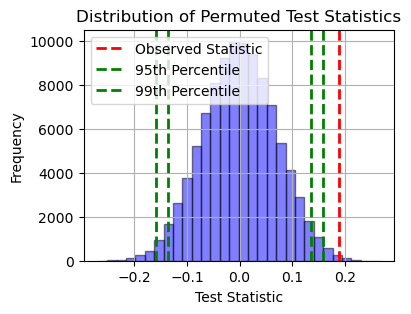

- p-value: 0.00259
- 99th percentile of permuted statistics: 0.15891417839632255
- Observed Test Statistic: 0.1878173237864238
cohens d = 0.9066336142773078
------------------


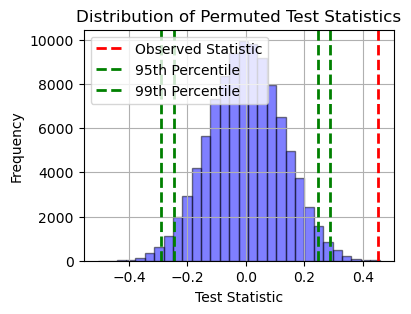

- p-value: 1e-05
- 99th percentile of permuted statistics: 0.2886909097248733
- Observed Test Statistic: 0.4530091076439036
cohens d = 1.8292287120721011
------------------


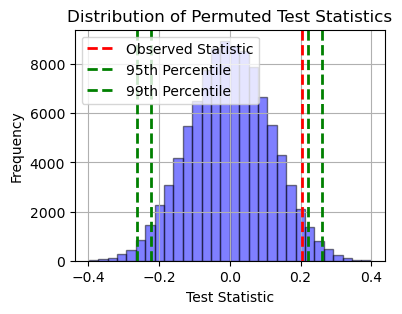

- p-value: 0.03749
- 99th percentile of permuted statistics: 0.2601918483882814
- Observed Test Statistic: 0.20309083127569588
cohens d = 0.8999170205608042


In [90]:

list1 = [float(item[0]) for item in expert_master['task_nontask']] 
list2 = [float(item[1]) for item in expert_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')


print('------------------')
list1 = [float(item[0]) for item in learning_master['task_nontask']] 
list2 = [float(item[1]) for item in learning_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list1 = [float(item[0]) for item in hlesion_master['task_nontask']] 
list2 = [float(item[1]) for item in hlesion_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

stats between groups

In [103]:
list1 = [float(item[0]) for item in expert_master['task_nontask']] 
list2 = [float(item[1]) for item in expert_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in learning_master['task_nontask']] 
list2 = [float(item[1]) for item in learning_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

list1 = [float(item[0]) for item in hlesion_master['task_nontask']] 
list2 = [float(item[1]) for item in hlesion_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))

ShapiroResult(statistic=np.float64(0.8953354267474212), pvalue=np.float64(0.028443815924771326))
ShapiroResult(statistic=np.float64(0.8953354267474206), pvalue=np.float64(0.028443815924770622))
ShapiroResult(statistic=np.float64(0.8410312655652665), pvalue=np.float64(0.016817171171969254))
ShapiroResult(statistic=np.float64(0.8410312655652663), pvalue=np.float64(0.016817171171969122))
ShapiroResult(statistic=np.float64(0.9575214030355926), pvalue=np.float64(0.7720539483267331))
ShapiroResult(statistic=np.float64(0.9575214030355926), pvalue=np.float64(0.7720539483267331))


In [126]:
#permanova for late vs early
permanova_ordered_misordered(expert_master['task_nontask'], learning_master['task_nontask'])
print('---------------------------------------------------')

#manova for late vs hlesion 

from statsmodels.multivariate.manova import MANOVA

# Your data
data = {
    'group': ['control']*len(conactinate_nth_items(expert_master['task_nontask'])[0]) +
             ['lesion']*len(conactinate_nth_items(hlesion_master['task_nontask'])[0]),
    'TASK': conactinate_nth_items(expert_master['task_nontask'])[0] +
            conactinate_nth_items(hlesion_master['task_nontask'])[0],
    'NONTASK': conactinate_nth_items(expert_master['task_nontask'])[1] +
               conactinate_nth_items(hlesion_master['task_nontask'])[1],
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('TASK + NONTASK ~ group', data=df)
res = manova.mv_test()
print(res)

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict




# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(res)
print("Partial eta-squared for each effect:", eta_squared)



method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  2
test statistic             2.943737
p-value                       0.113
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.56526
---------------------------------------------------
                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value          Num DF  Den DF         F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                -0.0000 2.0000 27.0000 -60798594969501712.0000 1.0000
         Pillai's trace                 1.0000 2.0000 27.0000 -60798594969501712.0000 1.0000
 Hotel

In [107]:
eta_squared

{'Intercept': np.float64(-26.0), 'group': np.float64(-26.0)}

# neuron involvement rate

In [142]:
def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship




def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):




    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_, alpha = 1, markeredgewidth = 0, markersize = 10)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')


    # Plot the original data and the fitted curve
    # plt.scatter(bin_centers, values, label='Data')
    # plt.plot(bin_centers, fitted_values, label='Fitted curve', color='red', alpha = 0.4)
    plt.xlabel('Bin Center')
    plt.ylabel('Value')




Fitted parameters: a = 0.03267556939789752, b = 3.21309210901926
R-squared: 0.9926259080124209
p-values: [np.float64(1.7030314393595702e-05), np.float64(1.1325253623795106e-08)]


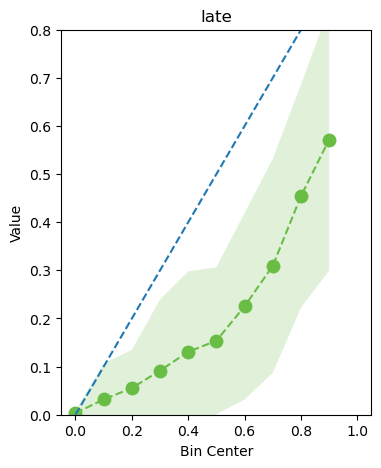

Fitted parameters: a = 0.03267556939789752, b = 3.21309210901926
R-squared: 0.9926259080124209
p-values: [np.float64(1.7030314393595702e-05), np.float64(1.1325253623795106e-08)]
Fitted parameters: a = 0.03879925261082293, b = 2.9611667306890963
R-squared: 0.9856101675654492
p-values: [np.float64(9.026715185722622e-05), np.float64(1.452690605585616e-07)]


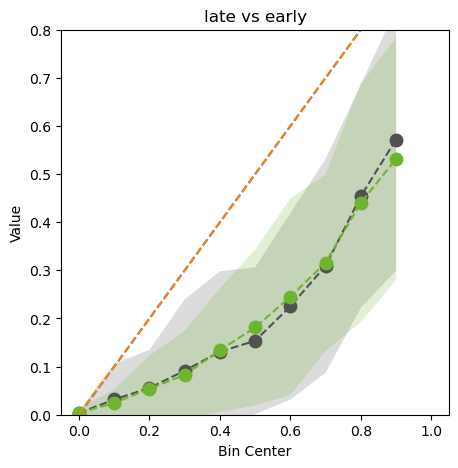

Fitted parameters: a = 0.03267556939789752, b = 3.21309210901926
R-squared: 0.9926259080124209
p-values: [np.float64(1.7030314393595702e-05), np.float64(1.1325253623795106e-08)]
Fitted parameters: a = 0.04664708148092975, b = 2.8513090514436104
R-squared: 0.9804219671492419
p-values: [np.float64(0.00016736150012919282), np.float64(4.0646521592968554e-07)]


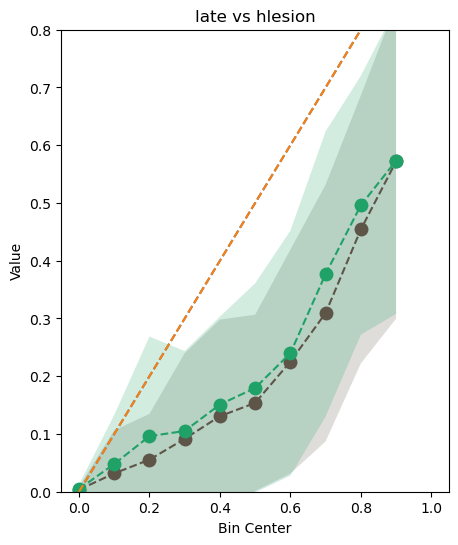

In [143]:

fig, ax = plt.subplots(1, 1,figsize=(4, 5))
late_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(expert_master['awake_seqbyseq_neuron_involvements'],expert_master['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(late_awake_sleep_relationship,'#69BD45',ax)
ax.set_title('late')
SaveFig('expert_neuron_awake_sleep_rel.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig, ax = plt.subplots(1, 1,figsize=(5, 5))
plot_awake_sleep_relationship(late_awake_sleep_relationship,'#515151',ax)
early_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(learning_master['awake_seqbyseq_neuron_involvements'],learning_master['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(early_awake_sleep_relationship,'#6DB52D',ax)
ax.set_title('late vs early')
SaveFig('expert_learning_neuron_awake_sleep_rel.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig, ax = plt.subplots(1, 1,figsize=(5, 6))
plot_awake_sleep_relationship(late_awake_sleep_relationship,'#5E5549',ax)
hlesion_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(hlesion_master['awake_seqbyseq_neuron_involvements'],hlesion_master['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(hlesion_awake_sleep_relationship,'#1FA168',ax)
ax.set_title('late vs hlesion')
SaveFig('expert_hlesion_neuron_awake_sleep_rel.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

stats 

In [176]:
def manova_groups_neuron_involvement(data1,data2):

    nrem_means = []
    for key in data1:
        if len(data1[key]) > 0:
            nrem_means += [np.nanmean(data1[key])]
    rem_means = []       
    for key in data2:
        if len(data2[key]) > 0:
            rem_means += [np.nanmean(data2[key])]

    x = nrem_means
    y = sorted(data1)

    x2 = rem_means
    y2 = sorted(data2)

    import statsmodels.api as sm
    from statsmodels.multivariate.manova import MANOVA

    A = pd.DataFrame({'x': x,
                    'y': y,
                    'groups': ['A'] * len(x)})
    B = pd.DataFrame({'x': x2,
                    'y': y2,
                    'groups': ['B'] * len(x2)})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)


    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    print(manova.mv_test())
    
    return manova.mv_test()
    
m = manova_groups_neuron_involvement(late_awake_sleep_relationship,early_awake_sleep_relationship)
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)

print('_________________________________________________________________________________________')
m = manova_groups_neuron_involvement(late_awake_sleep_relationship,hlesion_awake_sleep_relationship)
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)




                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3415 2.0000 17.0000 16.3933 0.0001
         Pillai's trace 0.6585 2.0000 17.0000 16.3933 0.0001
 Hotelling-Lawley trace 1.9286 2.0000 17.0000 16.3933 0.0001
    Roy's greatest root 1.9286 2.0000 17.0000 16.3933 0.0001
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9998 2.0000 17.0000  0.0016 0.9984
         Pillai's trace 0.0002 2.0000 17.0000  0.0016 0.9984
 Hotelling-Lawley trace 0.0002 2.0000 17.0